# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "[Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value](https://proceedings.mlr.press/v202/kwon23e.html)" ICML 2023 , using pyDVL.


The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std

from pydvl.value.result import ValuationResult

In [2]:

from pydvl.value.result import ValuationResult
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor# train an ECOD detector
from pyod.models.ecod import ECOD

In [3]:
from pydvl.reporting.plots import plot_best_worst, compute_best_worst_scores, plot_methods_linreg


In [4]:
def func(utility, method_name):
    if method_name == "Random":
            values = ValuationResult.from_random(size=len(utility.data))
    elif method_name == "IsolationForest":
        model = IsolationForest()
        model.fit(utility.data.x_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "LocalOutlierFactor":
        model = LocalOutlierFactor(novelty=True).fit(utility.data.x_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "OneClassSVM":
        model = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1).fit(utility.data.x_train, utility.data.y_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "EllipticEnvelope":
        model = EllipticEnvelope(random_state=0).fit(utility.data.x_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "oob":
        values = compute_data_oob(utility, n_est=20, max_samples=0.80)
    elif method_name == "EOCD":       
        clf = ECOD()
        clf.fit(utility.data.x_train)
        values = ValuationResult(values = clf.decision_scores_ )
    return values

methods =  ["Random","IsolationForest",
                            "LocalOutlierFactor","OneClassSVM", "EllipticEnvelope","oob","EOCD"]
kwargs_list = [{"method_name":m} for m in methods]

# Iris Dataset

In [5]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [6]:
model = DecisionTreeClassifier()

utility = Utility(model, data, Scorer("accuracy", default=0.0))

Text(0.5, 1.0, 'ECOD')

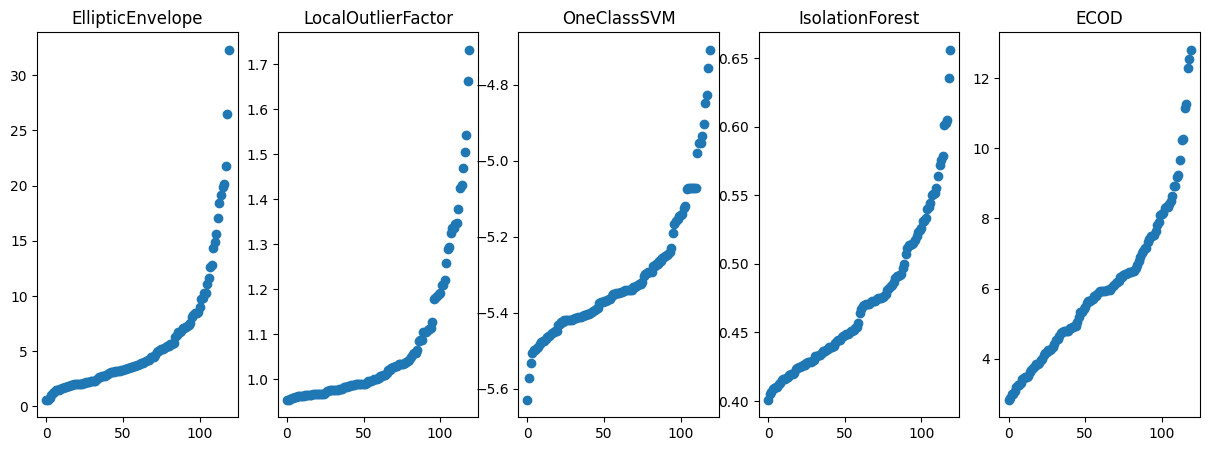

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[15,5])
for i, (model, name) in enumerate(zip([EllipticEnvelope(random_state=0), LocalOutlierFactor(novelty=True),
                svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1), IsolationForest()], ["EllipticEnvelope", 
"LocalOutlierFactor",
"OneClassSVM",
"IsolationForest"])):#sklearn
    model.fit(utility.data.x_train)
    vals = -model.score_samples(utility.data.x_train)
    ax[i].scatter(np.arange(len(vals)), sorted(vals))
    ax[i].set_title(name)
    #vals = Normalizer().transform([vals])[0]
    #ax[i//2,i%2].scatter(np.arange(len(vals)), sorted(vals))
    #ax[1,i].scatter(np.arange(len(vals)), sorted(vals))
    

clf = ECOD()
clf.fit(utility.data.x_train)
# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
#vals = clf.decision_function(utility.data.x_test)  # predict raw outlier scores on test
ax[-1].scatter(np.arange(len(y_train_scores)), sorted(y_train_scores))
ax[-1].set_title("ECOD")

## DecisionTreeClassifier

In [8]:

model_eval = DecisionTreeClassifier(max_depth=8)
#model_eval = DecisionTreeClassifier(max_depth=8)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

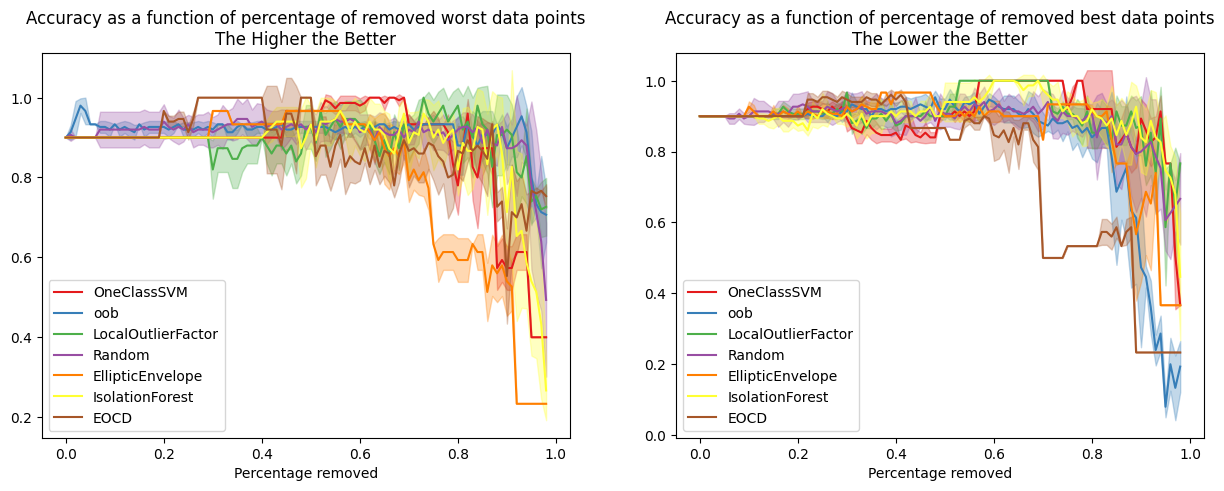

In [9]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

In [11]:
from pydvl.reporting.plots import plot_best_worst_class_imbalance

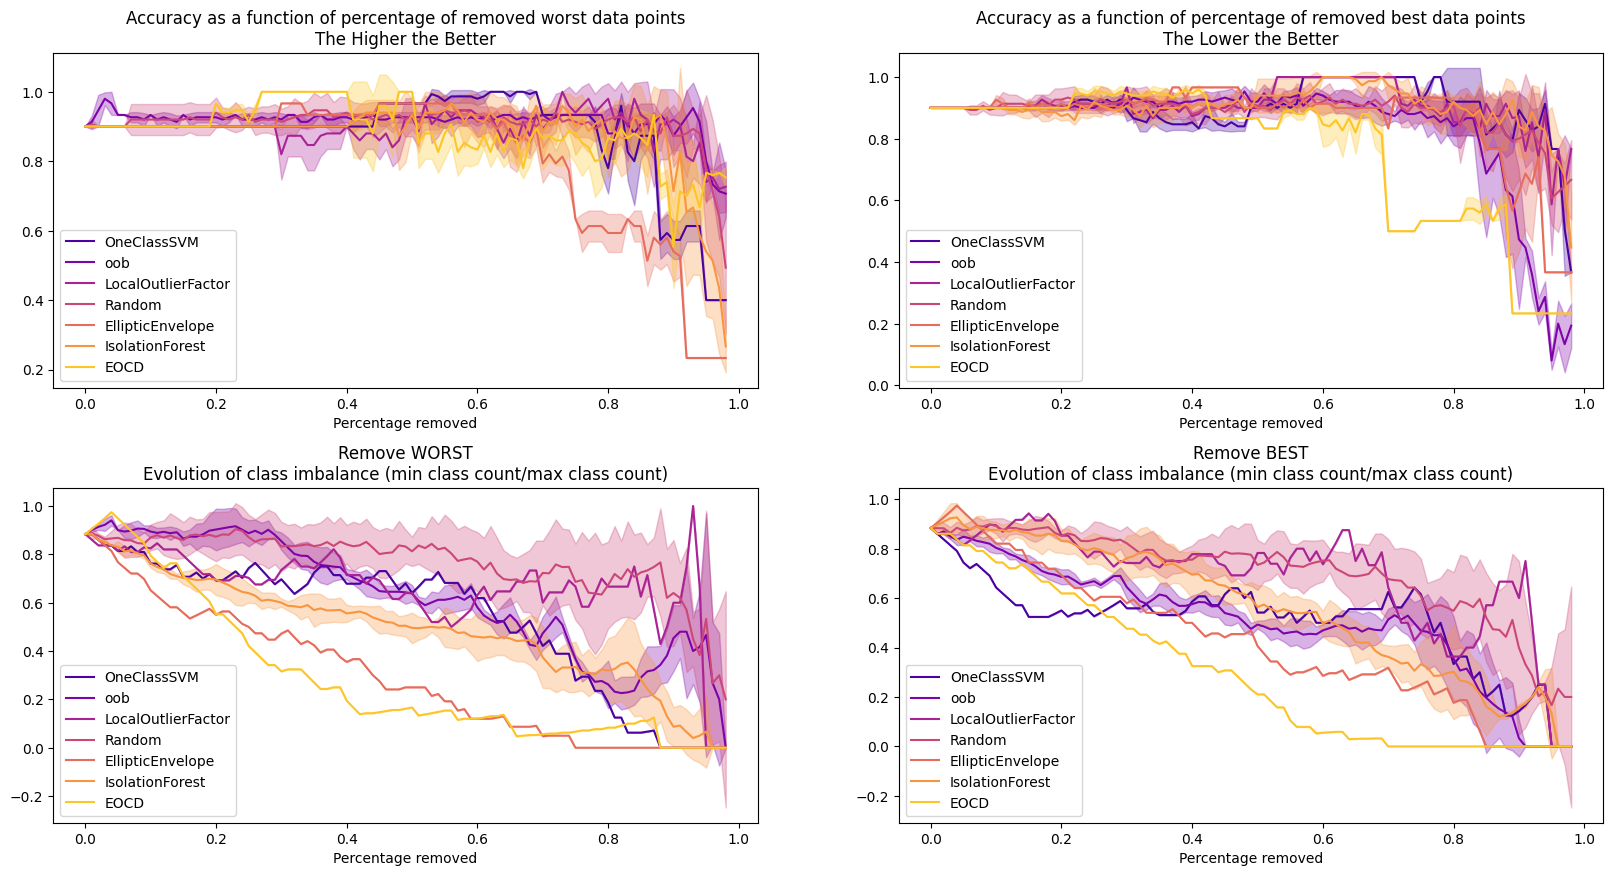

In [12]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

In [10]:
from pydvl.reporting.plots import plot_methods_linreg

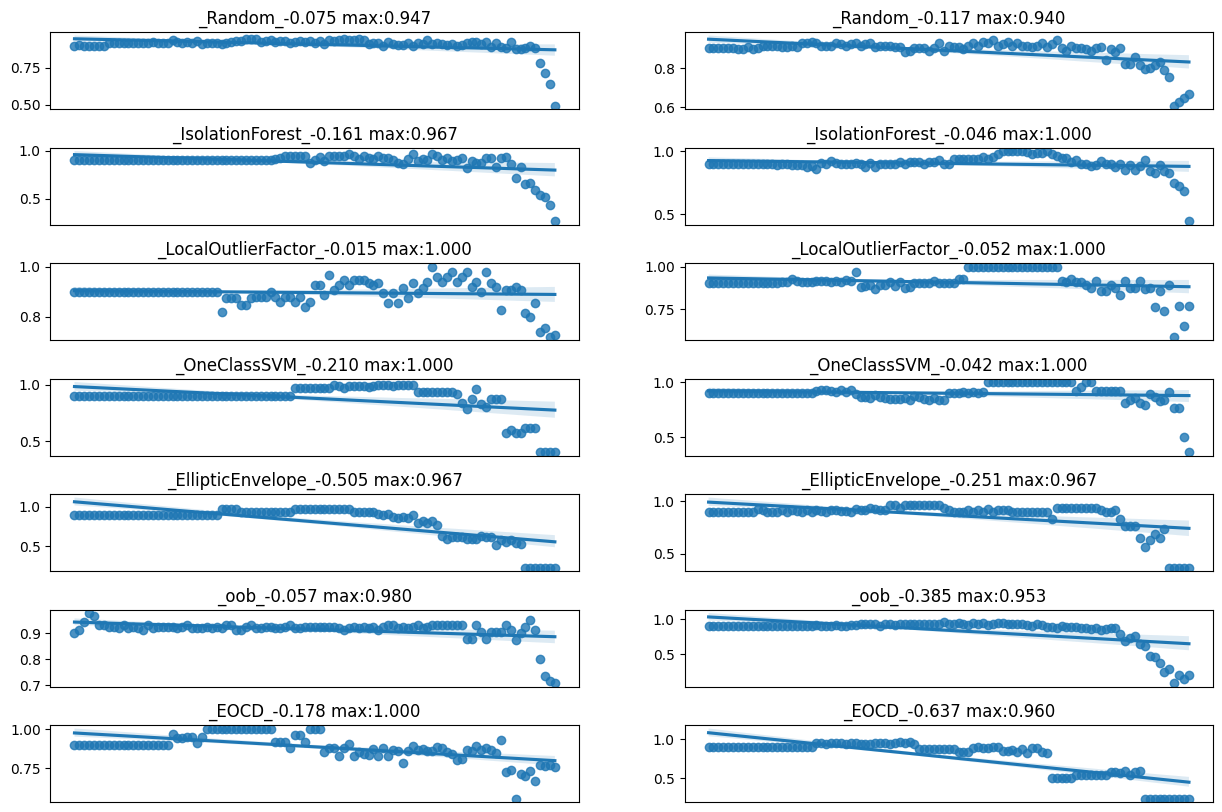

In [13]:
plot_methods_linreg(best_scores_df, worst_scores_df)

## LGBM

In [14]:
from lightgbm import LGBMClassifier

In [15]:

model_eval = LGBMClassifier(verbose=-1)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

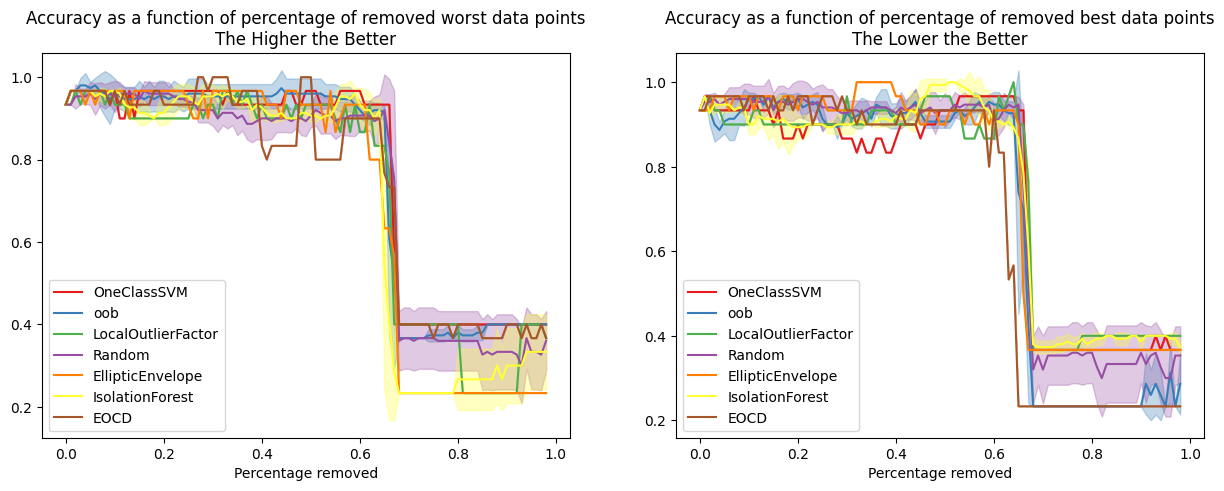

In [16]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

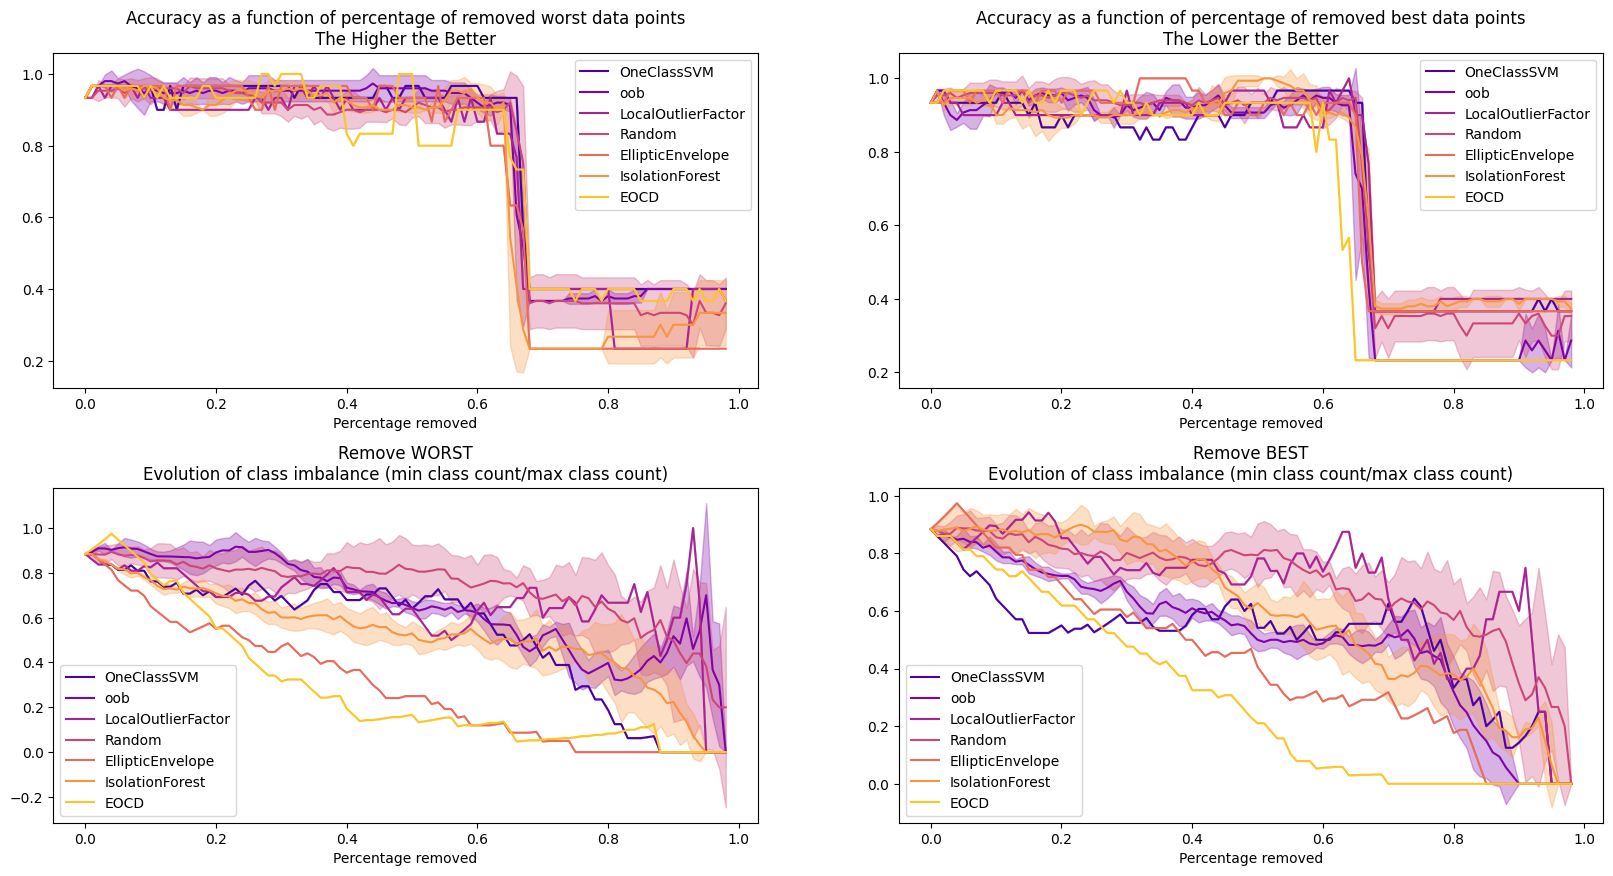

In [17]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

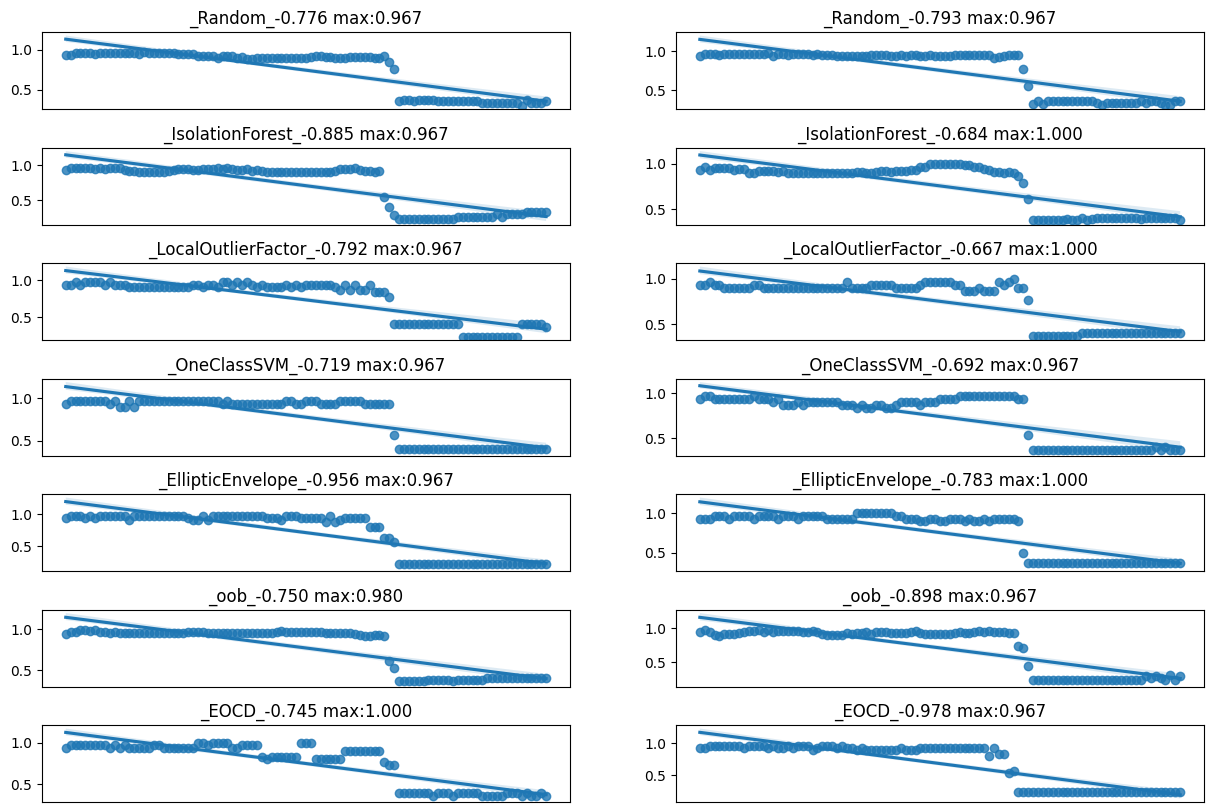

In [18]:
plot_methods_linreg(best_scores_df, worst_scores_df)

In [19]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [20]:
model = DecisionTreeClassifier()

utility = Utility(model, data, Scorer("accuracy", default=0.0))

Text(0.5, 1.0, 'ECOD')

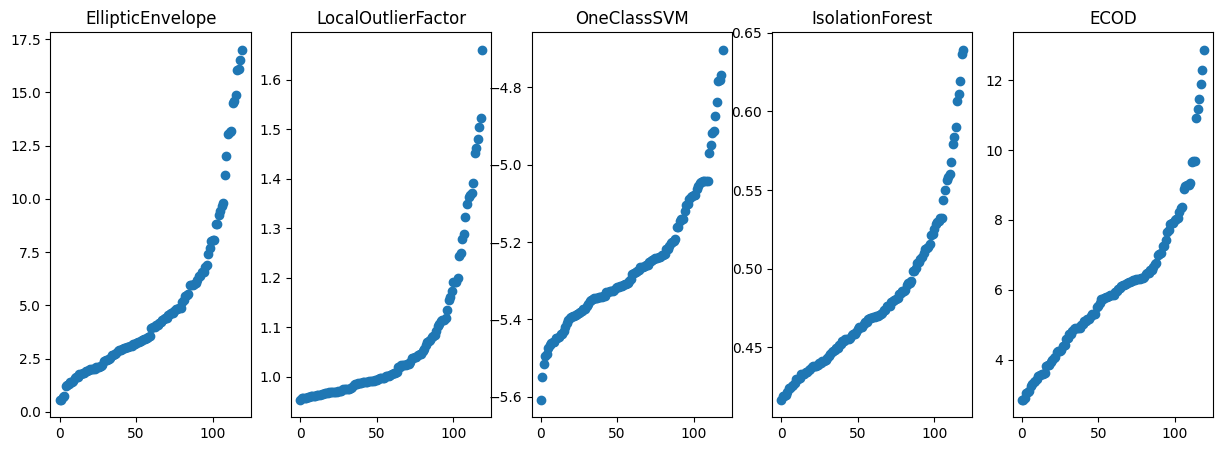

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[15,5])
for i, (model, name) in enumerate(zip([EllipticEnvelope(random_state=0), LocalOutlierFactor(novelty=True),
                svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1), IsolationForest()], ["EllipticEnvelope", 
"LocalOutlierFactor",
"OneClassSVM",
"IsolationForest"])):#sklearn
    model.fit(utility.data.x_train)
    vals = -model.score_samples(utility.data.x_train)
    ax[i].scatter(np.arange(len(vals)), sorted(vals))
    ax[i].set_title(name)
    
    #vals = Normalizer().transform([vals])[0]
    #ax[i//2,i%2].scatter(np.arange(len(vals)), sorted(vals))
    #ax[1,i].scatter(np.arange(len(vals)), sorted(vals))
    

clf = ECOD()
clf.fit(utility.data.x_train)
# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
#vals = clf.decision_function(utility.data.x_test)  # predict raw outlier scores on test
ax[-1].scatter(np.arange(len(y_train_scores)), sorted(y_train_scores))
ax[-1].set_title("ECOD")

# Diabetes DATASET

In [35]:
import pandas as pd
from sklearn.datasets import load_diabetes, load_wine

data = Dataset.from_sklearn(load_wine())

In [36]:
model = DecisionTreeClassifier()

utility = Utility(model, data, Scorer("accuracy", default=0.0))

## DecisionTreeClassifier

In [37]:

model_eval = DecisionTreeClassifier(max_depth=8)
#model_eval = DecisionTreeClassifier(max_depth=8)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

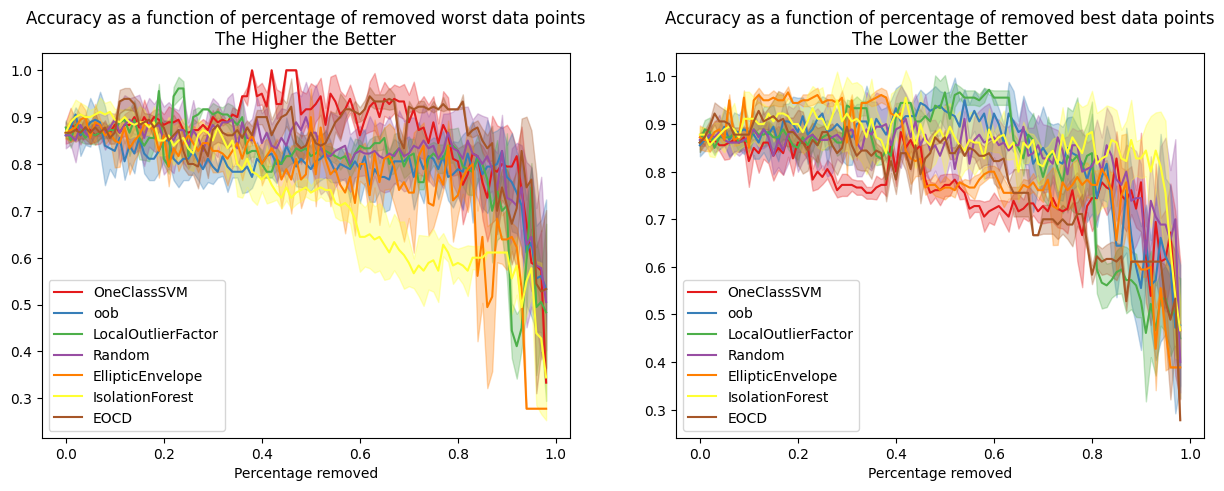

In [38]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

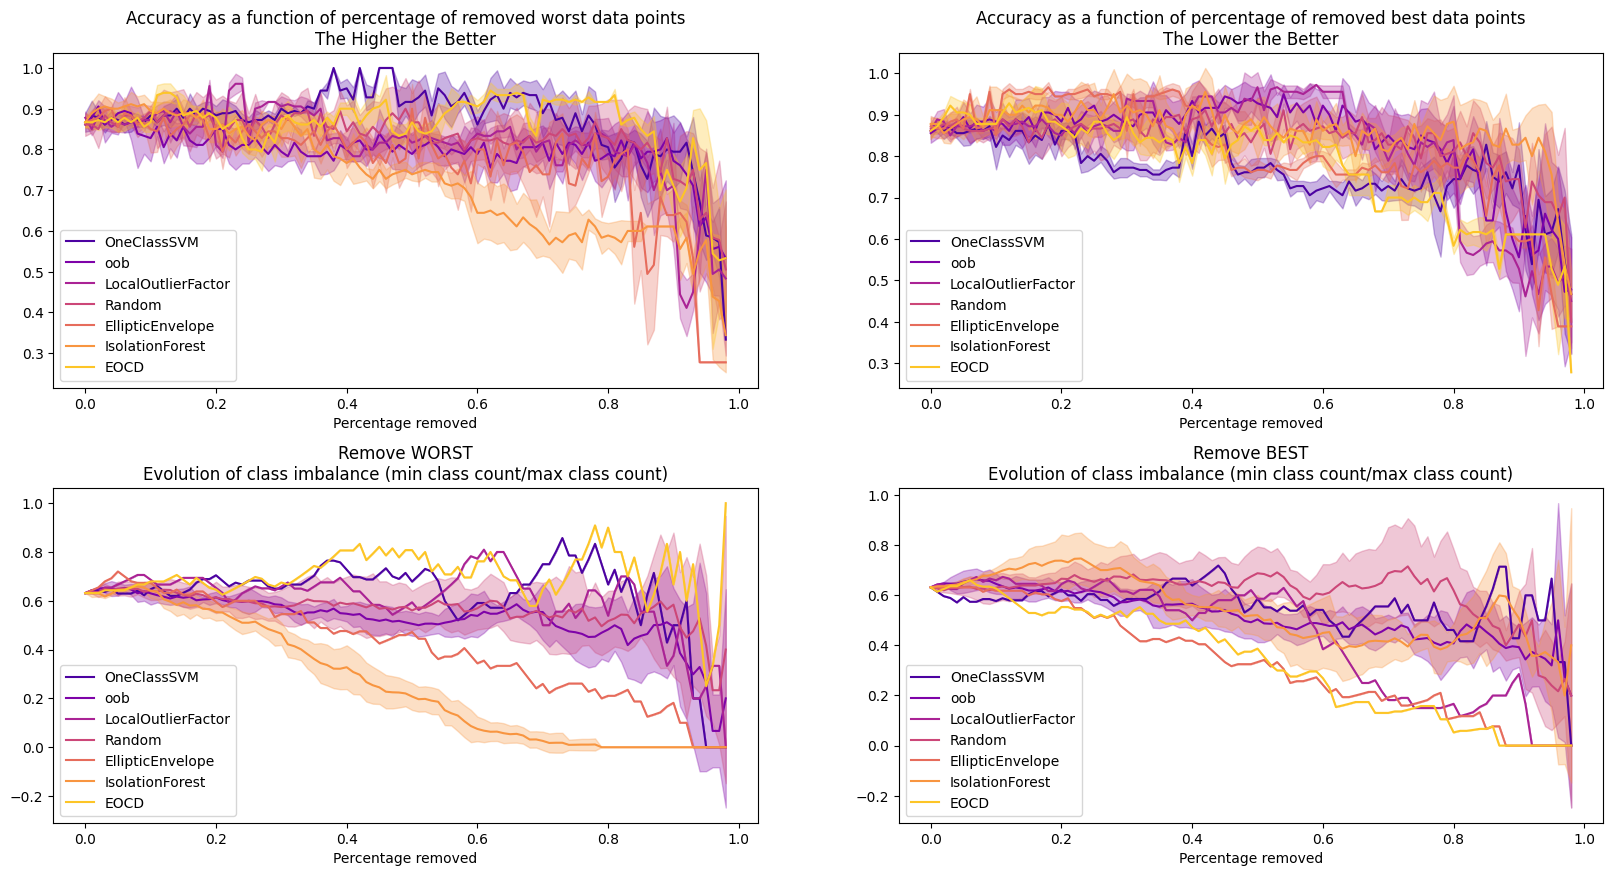

In [39]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

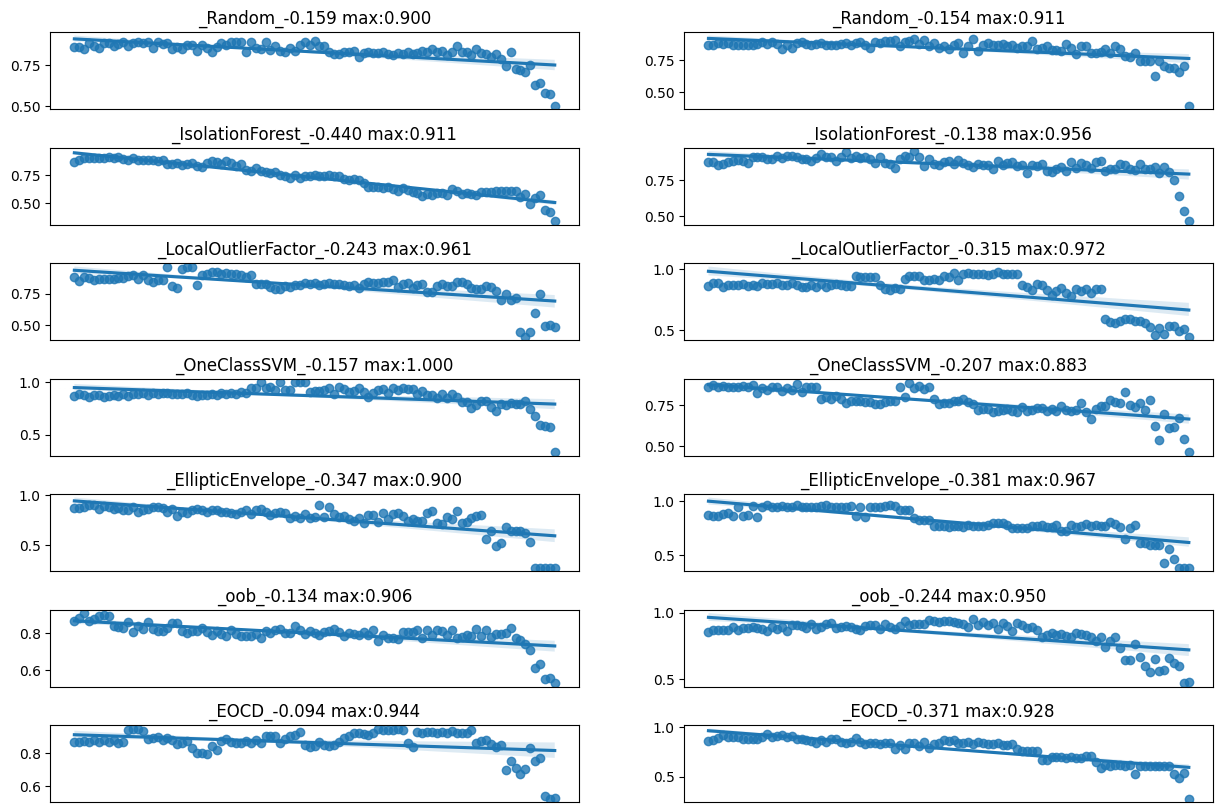

In [40]:
plot_methods_linreg(best_scores_df, worst_scores_df)

## LGBM

In [41]:
from lightgbm import LGBMClassifier

In [42]:

model_eval = LGBMClassifier(verbose=-1)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.02)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

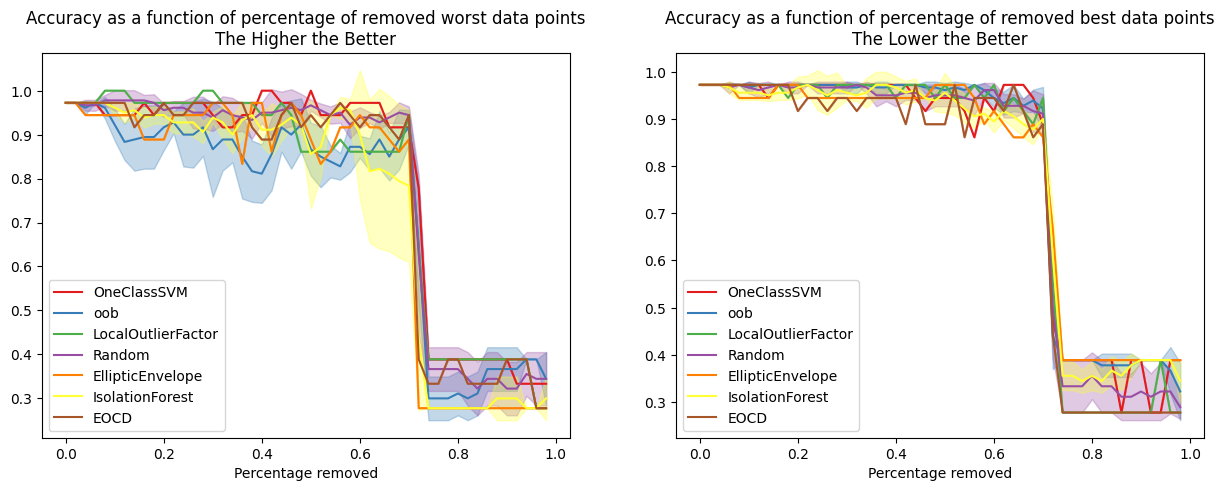

In [43]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

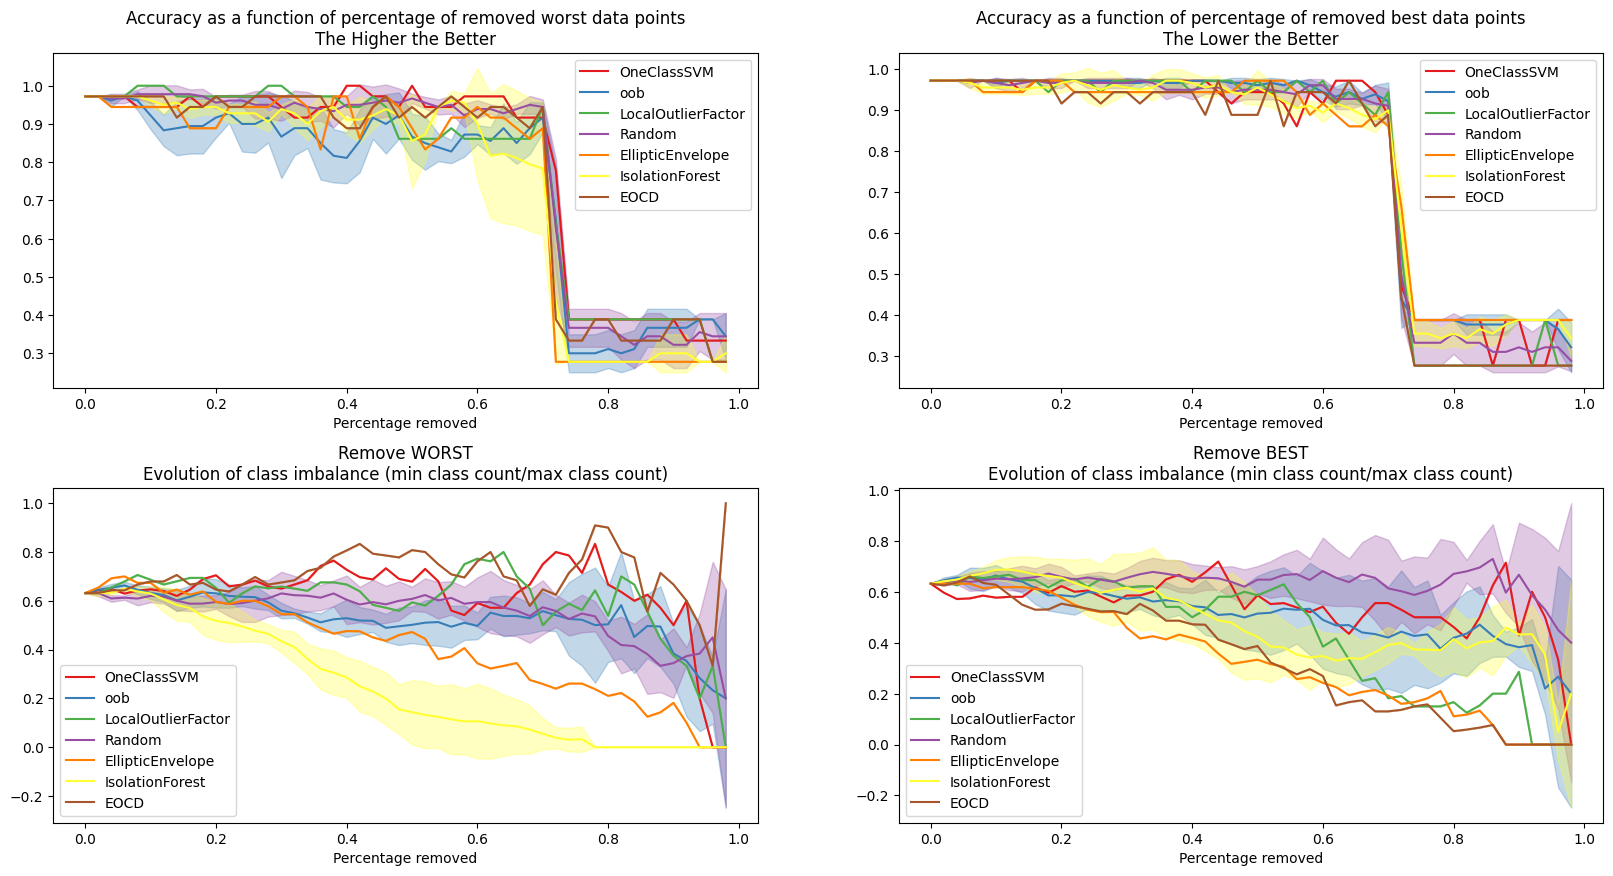

In [44]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

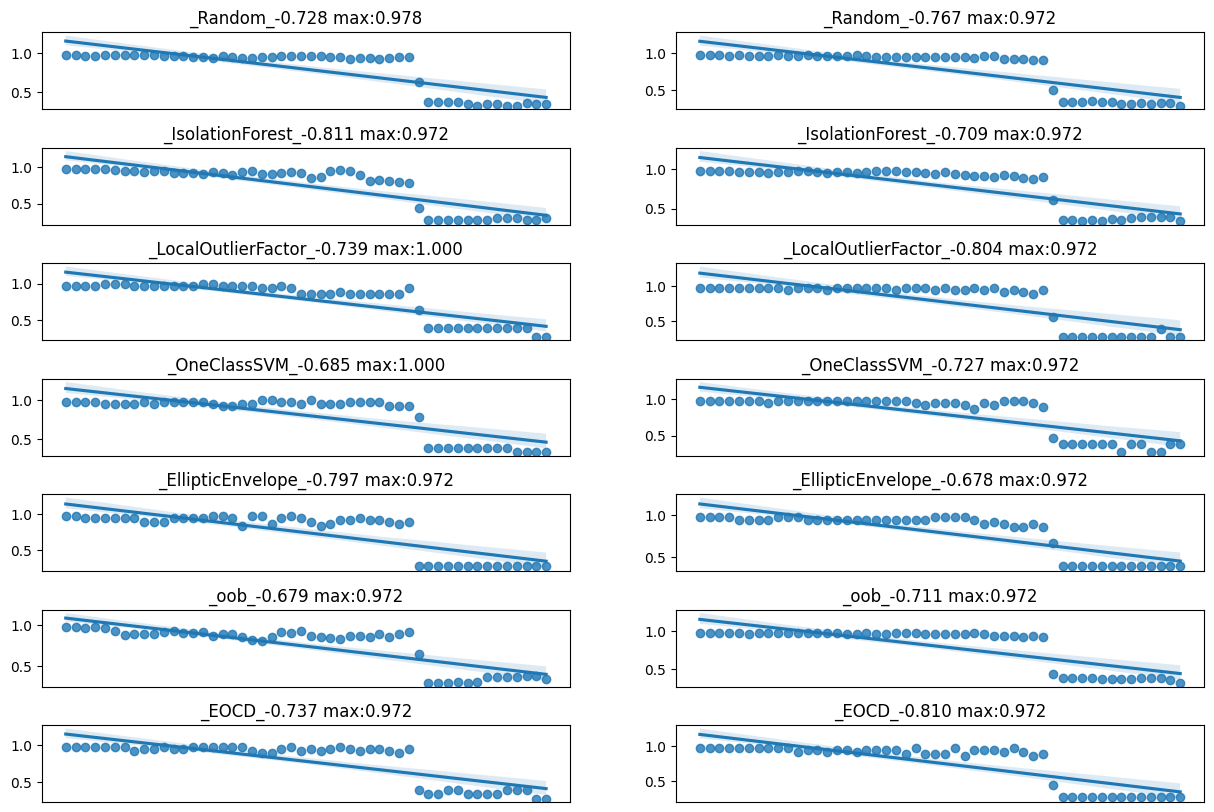

In [45]:
plot_methods_linreg(best_scores_df, worst_scores_df)

# Adult Dataset

In [ ]:
import pandas as pd

# Specify the URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Specify the column names
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# Specify the data types for each column
data_types = {
    "age": int,
    "workclass": "category",
    "fnlwgt": int,
    "education": "category",
    "education-num": int,
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "sex": "category",
    "capital-gain": int,
    "capital-loss": int,
    "hours-per-week": int,
    "native-country": "category",
    "income": "category",
}

# Load the dataset into a pandas DataFrame
data_adult = pd.read_csv(
    url,
    names=column_names,
    sep=",\s*",
    engine="python",
    na_values="?",
    dtype=data_types,
    nrows=10000,
)

# Drop categorical columns
data_adult = data_adult.drop(
    columns=[
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ]
)


# Display the first few rows of the dataframe
print(data_adult.head())

   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

  income  
0  <=50K  
1  <=50K  
2  <=50K  
3  <=50K  
4  <=50K  


In [ ]:
data = Dataset.from_arrays(
    X=data_adult.drop(columns=["income"]).values,
    y=data_adult.loc[:, "income"].cat.codes.values,
)

model = KNeighborsClassifier(n_neighbors=5)

utility = Utility(model, data, Scorer("accuracy", default=0.0))

Text(0.5, 1.0, 'ECOD')

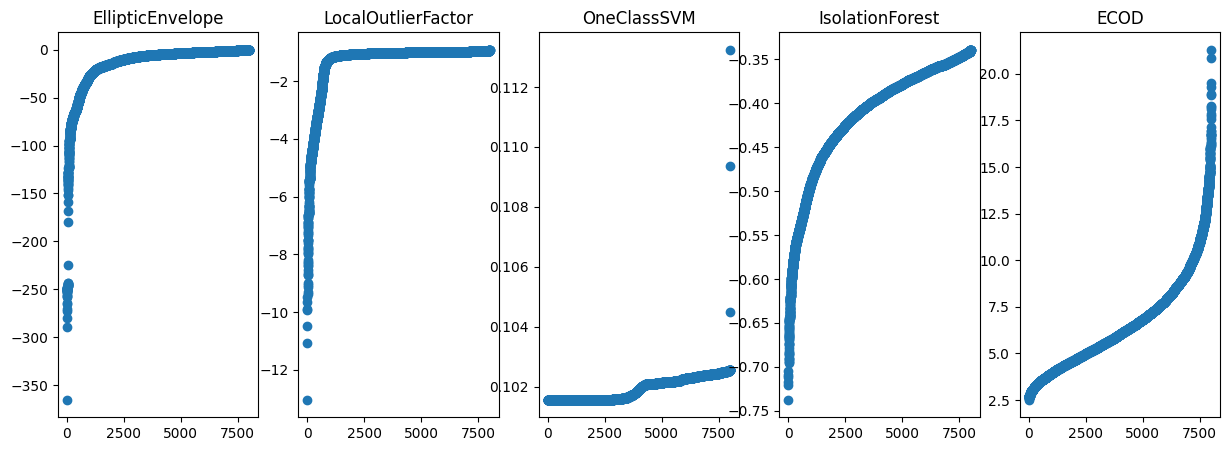

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[15,5])
for i, (model, name) in enumerate(zip([EllipticEnvelope(random_state=0), LocalOutlierFactor(novelty=True),
                svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1), IsolationForest()], ["EllipticEnvelope", 
"LocalOutlierFactor",
"OneClassSVM",
"IsolationForest"])):#sklearn
    model.fit(utility.data.x_train)
    vals = -model.score_samples(utility.data.x_train)
    ax[i].scatter(np.arange(len(vals)), sorted(vals))
    ax[i].set_title(name)
    #vals = Normalizer().transform([vals])[0]
    #ax[i//2,i%2].scatter(np.arange(len(vals)), sorted(vals))
    #ax[1,i].scatter(np.arange(len(vals)), sorted(vals))
    

clf = ECOD()
clf.fit(utility.data.x_train)
# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
#vals = clf.decision_function(utility.data.x_test)  # predict raw outlier scores on test
ax[-1].scatter(np.arange(len(y_train_scores)), sorted(y_train_scores))
ax[-1].set_title("ECOD")

## DecisionTreeClassifier

In [ ]:

model_eval = DecisionTreeClassifier(max_depth=8)
#model_eval = DecisionTreeClassifier(max_depth=8)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df = compute_best_worst_scores(utility, utility_eval,
                                                    removal_percentages, n_iter, func,f_name="", kwargs_list=kwargs_list)

ValueError: The number of values, 7999, should be equal to the number of data indices, 8000

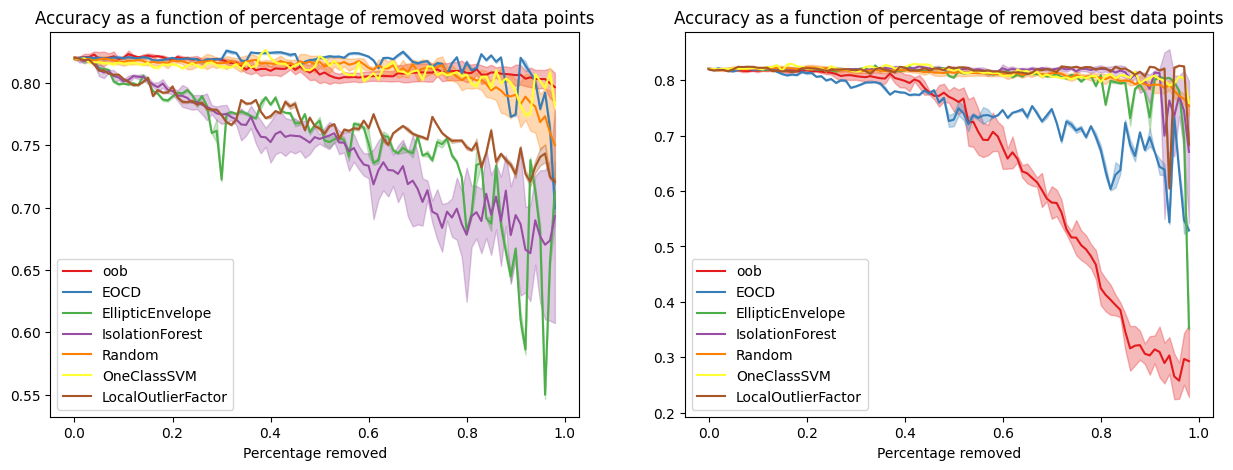

In [ ]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

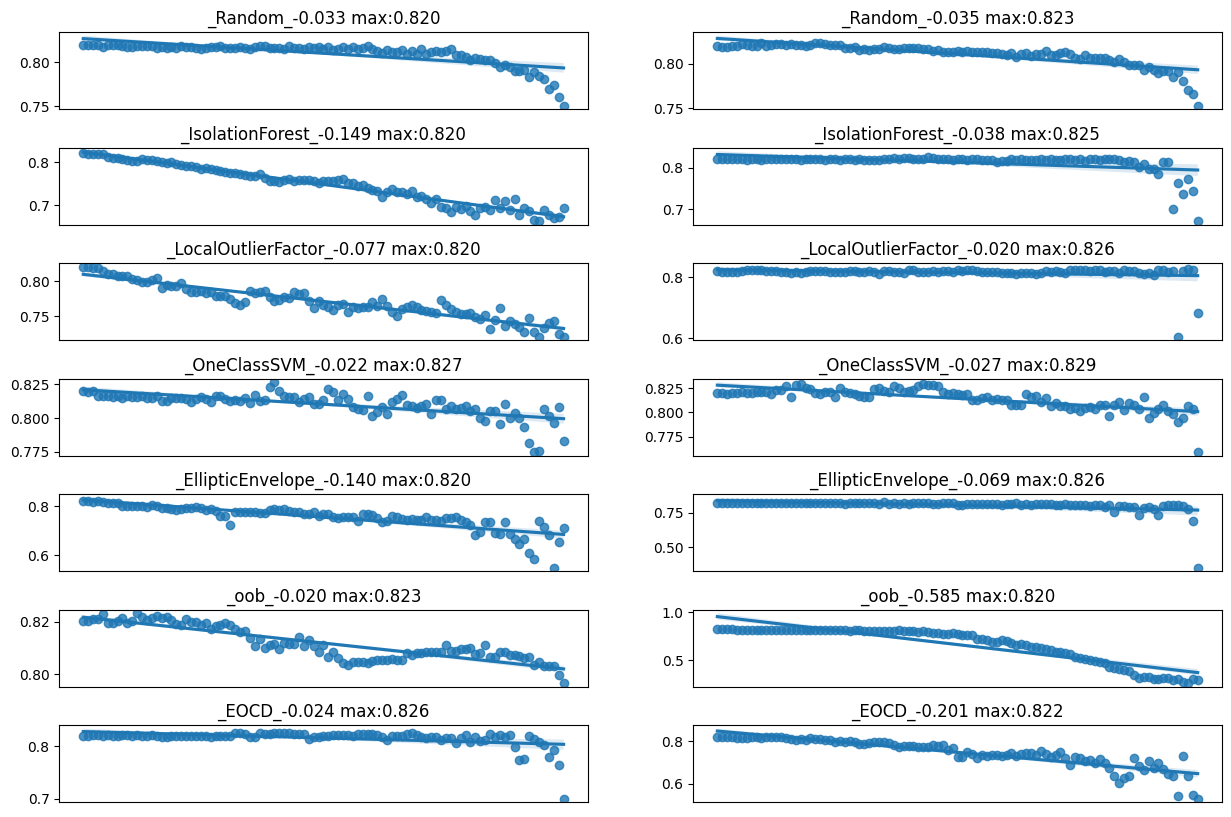

In [ ]:
plot_methods_linreg(best_scores_df, worst_scores_df)

## LGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:

model_eval = LGBMClassifier(verbose=-1)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df = compute_best_worst_scores(utility, utility_eval,
                                                    removal_percentages, n_iter, func,f_name="", kwargs_list=kwargs_list)

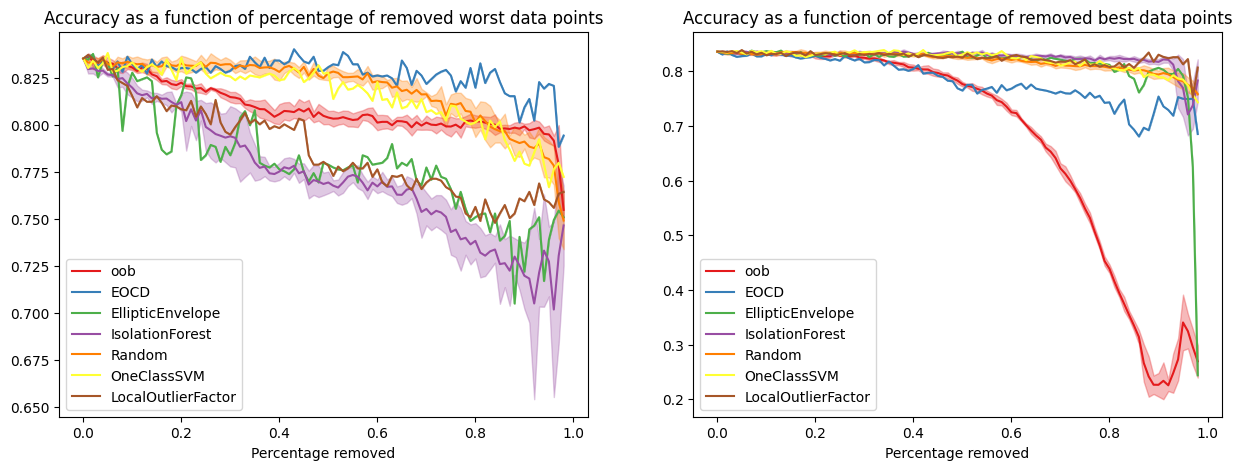

In [ ]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

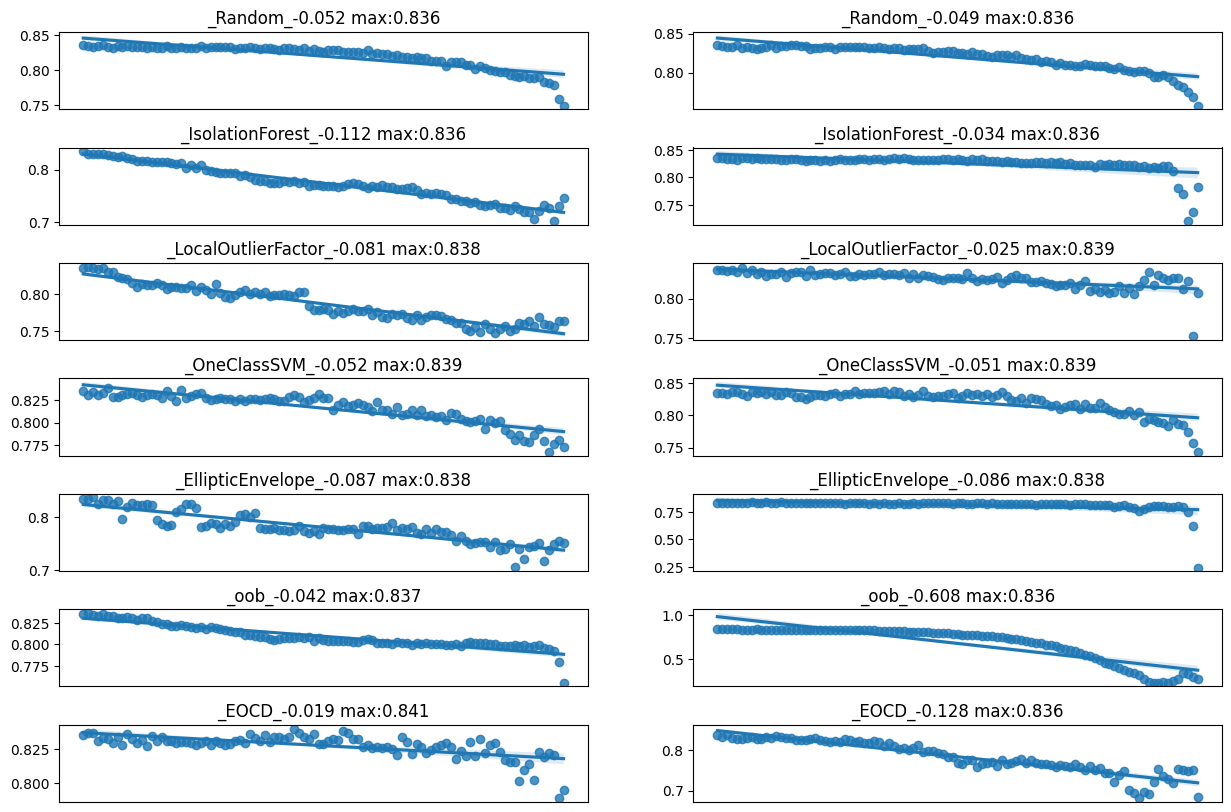

In [ ]:
plot_methods_linreg(best_scores_df, worst_scores_df)

# Py OD

# ADBENCH

In [ ]:
! python3 -m pip install adbench

In [ ]:
from adbench.myutils import Utils
utils = Utils() # utility function
# download datasets from the remote github repo
# we recommend jihulab for China mainland user and github otherwise
utils.download_datasets(repo='github')


2023-09-18 11:56:59.929570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 11:57:00.984404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


if there is any question while downloading datasets, we suggest you to download it from the website:
https://github.com/Minqi824/ADBench/tree/main/adbench/datasets
如果您在中国大陆地区，请使用链接：
https://jihulab.com/BraudoCC/ADBench_datasets/


100%|██████████| 3/3 [00:00<00:00, 1674.15it/s]

Current saving path: /home/bastienzim/Documents/ShapleyDirs/pyDVL/venv/lib/python3.8/site-packages/adbench/datasets/CV_by_ResNet18
CV_by_ResNet18 already exists. Skipping download...
Current saving path: /home/bastienzim/Documents/ShapleyDirs/pyDVL/venv/lib/python3.8/site-packages/adbench/datasets/NLP_by_BERT
NLP_by_BERT already exists. Skipping download...
Current saving path: /home/bastienzim/Documents/ShapleyDirs/pyDVL/venv/lib/python3.8/site-packages/adbench/datasets/Classical
Classical already exists. Skipping download...


In [ ]:
# customized model on ADBench's datasets
from adbench.run import RunPipeline
from adbench.baseline.Customized.run import Customized


In [ ]:
Customized

adbench.baseline.Customized.run.Customized

In [ ]:
from sklearn.linear_model import LogisticRegression
from adbench.myutils import Utils
from adbench.baseline.Customized.fit import fit
from adbench.baseline.Customized.model import LR

class Customized():
    '''
    You should define the following fit and predict_score function
    Here we use the LogisticRegression as an example
    '''
    def __init__(self, seed:int, model_name:str=None):
        self.seed = seed
        self.utils = Utils()
        self.model_name = model_name

    def fit(self, X_train, y_train):
        # Initialization
        #model = KNeighborsClassifier(n_neighbors=5)
        #data = Dataset.from_arrays(
        #    X=data_adult.drop(columns=["income"]).values,
        #    y=data_adult.loc[:, "income"].cat.codes.values,
        #)
        #self.utility = Utility(model, data, Scorer("accuracy", default=0.0))



        self.model = LR(random_state=self.seed)

        # fitting
        self.model = fit(X_train=X_train, y_train=y_train, model=self.model)

        return self

    def predict_score(self, X):
        score = self.model.predict_proba(X)[:, 1]
        return score

In [ ]:
help(Customized)

Help on class Customized in module __main__:

class Customized(builtins.object)
 |  Customized(seed: int, model_name: str = None)
 |  
 |  You should define the following fit and predict_score function
 |  Here we use the LogisticRegression as an example
 |  
 |  Methods defined here:
 |  
 |  __init__(self, seed: int, model_name: str = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, X_train, y_train)
 |  
 |  predict_score(self, X)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:

# notice that you should specify the corresponding category of your customized AD algorithm
# for example, here we use Logistic Regression as customized clf, which belongs to the supervised algorithm
# for your own algorithm, you can realize the same usage as other baselines by modifying the fit.py, model.py, and run.py files in the adbench/baseline/Customized
pipeline = RunPipeline(suffix='ADBench', parallel='supervise', realistic_synthetic_mode=None, noise_type=None)
results = pipeline.run(clf=Customized)

# customized model on customized dataset
import numpy as np
dataset = {}
dataset['X'] = np.random.randn(1000, 20)
dataset['y'] = np.random.choice([0, 1], 1000)
results = pipeline.run(dataset=dataset, clf=Customized)

current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 42, 'Anomalies Ratio(%)': 4.2}
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 42, 'Anomalies Ratio(%)': 4.2}
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 34, 'Anomalies Ratio(%)': 3.4}
current noise type: None
{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
current noise type: None
{'Samples': 5803, 'Features': 36, 'Anomalies': 71, 'Anomalies Ratio(%)': 1.22}
current noise type

7it [00:00, 61.65it/s]

generating duplicate samples for dataset MVTec-AD_tile...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 227, 'Anomalies Ratio(%)': 22.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_tile', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_tile...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 227, 'Anomalies Ratio(%)': 22.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, 

31it [00:00, 87.73it/s]

generating duplicate samples for dataset MVTec-AD_tile...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 227, 'Anomalies Ratio(%)': 22.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_tile', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_tile...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 227, 'Anomalies Ratio(%)': 22.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self,

49it [00:00, 83.60it/s]

generating duplicate samples for dataset MVTec-AD_cable...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 251, 'Anomalies Ratio(%)': 25.1}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_cable', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_cable...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 251, 'Anomalies Ratio(%)': 25.1}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (se

58it [00:00, 55.23it/s]

generating duplicate samples for dataset 45_wine...
current noise type: None
{'Samples': 1000, 'Features': 13, 'Anomalies': 75, 'Anomalies Ratio(%)': 7.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('45_wine', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 45_wine...
current noise type: None
{'Samples': 1000, 'Features': 13, 'Anomalies': 80, 'Anomalies Ratio(%)': 8.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't

71it [00:01, 45.94it/s]

generating duplicate samples for dataset 45_wine...
current noise type: None
{'Samples': 1000, 'Features': 13, 'Anomalies': 88, 'Anomalies Ratio(%)': 8.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('45_wine', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 45_wine...
current noise type: None
{'Samples': 1000, 'Features': 13, 'Anomalies': 75, 'Anomalies Ratio(%)': 7.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't

77it [00:01, 43.74it/s]

generating duplicate samples for dataset 37_Stamps...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 95, 'Anomalies Ratio(%)': 9.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('37_Stamps', 0.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 37_Stamps...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 100, 'Anomalies Ratio(%)': 10.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) d

87it [00:01, 41.45it/s]

generating duplicate samples for dataset 37_Stamps...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 90, 'Anomalies Ratio(%)': 9.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('37_Stamps', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 37_Stamps...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 95, 'Anomalies Ratio(%)': 9.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doe

92it [00:01, 40.75it/s]

generating duplicate samples for dataset 37_Stamps...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 100, 'Anomalies Ratio(%)': 10.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('37_Stamps', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 37_Stamps...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 90, 'Anomalies Ratio(%)': 9.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) d

109it [00:02, 56.50it/s]

generating duplicate samples for dataset MVTec-AD_capsule...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 308, 'Anomalies Ratio(%)': 30.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_capsule', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_capsule...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 308, 'Anomalies Ratio(%)': 30.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with construct

133it [00:02, 77.71it/s]

generating duplicate samples for dataset MVTec-AD_zipper...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 305, 'Anomalies Ratio(%)': 30.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_zipper', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_zipper...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 305, 'Anomalies Ratio(%)': 30.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (

145it [00:02, 84.67it/s]

generating duplicate samples for dataset MVTec-AD_zipper...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 305, 'Anomalies Ratio(%)': 30.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_zipper', 1.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 15_Hepatitis...
current noise type: None
{'Samples': 1000, 'Features': 19, 'Anomalies': 170, 'Anomalies Ratio(%)': 17.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self

154it [00:02, 64.13it/s]

generating duplicate samples for dataset 15_Hepatitis...
current noise type: None
{'Samples': 1000, 'Features': 19, 'Anomalies': 139, 'Anomalies Ratio(%)': 13.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('15_Hepatitis', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 15_Hepatitis...
current noise type: None
{'Samples': 1000, 'Features': 19, 'Anomalies': 169, 'Anomalies Ratio(%)': 16.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *arg

162it [00:02, 55.33it/s]

generating duplicate samples for dataset 15_Hepatitis...
current noise type: None
{'Samples': 1000, 'Features': 19, 'Anomalies': 170, 'Anomalies Ratio(%)': 17.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('15_Hepatitis', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 15_Hepatitis...
current noise type: None
{'Samples': 1000, 'Features': 19, 'Anomalies': 139, 'Anomalies Ratio(%)': 13.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args

181it [00:03, 59.14it/s]

generating duplicate samples for dataset 15_Hepatitis...
current noise type: None
{'Samples': 1000, 'Features': 19, 'Anomalies': 169, 'Anomalies Ratio(%)': 16.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('15_Hepatitis', 1.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_carpet...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 254, 'Anomalies Ratio(%)': 25.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *

193it [00:03, 68.42it/s]

current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 254, 'Anomalies Ratio(%)': 25.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_carpet', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_carpet...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 254, 'Anomalies Ratio(%)': 25.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Curr

214it [00:03, 79.21it/s]

generating duplicate samples for dataset MVTec-AD_transistor...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 115, 'Anomalies Ratio(%)': 11.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_transistor', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_transistor...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 115, 'Anomalies Ratio(%)': 11.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with 

238it [00:03, 87.34it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_screw', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_screw...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 240, 'Anomalies Ratio(%)': 24.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_screw', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr':

247it [00:03, 73.16it/s]

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 138, 'Anomalies Ratio(%)': 13.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('39_vertebral', 0.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 133, 'Anomalies Ratio(%)': 13.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, 

255it [00:04, 57.14it/s]

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 123, 'Anomalies Ratio(%)': 12.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('39_vertebral', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 138, 'Anomalies Ratio(%)': 13.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, 

262it [00:04, 47.31it/s]

generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 133, 'Anomalies Ratio(%)': 13.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('39_vertebral', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 39_vertebral...
current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 123, 'Anomalies Ratio(%)': 12.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, 

268it [00:04, 46.18it/s]

current noise type: None
{'Samples': 1000, 'Features': 6, 'Anomalies': 133, 'Anomalies Ratio(%)': 13.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('39_vertebral', 1.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_toothbrush...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 271, 'Anomalies Ratio(%)': 27.1}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Curre

286it [00:04, 59.26it/s]

generating duplicate samples for dataset MVTec-AD_toothbrush...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 271, 'Anomalies Ratio(%)': 27.1}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_toothbrush', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_toothbrush...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 271, 'Anomalies Ratio(%)': 27.1}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with c

293it [00:04, 53.96it/s]

generating duplicate samples for dataset 21_Lymphography...
current noise type: None
{'Samples': 1000, 'Features': 18, 'Anomalies': 44, 'Anomalies Ratio(%)': 4.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('21_Lymphography', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 21_Lymphography...
current noise type: None
{'Samples': 1000, 'Features': 18, 'Anomalies': 38, 'Anomalies Ratio(%)': 3.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self,

304it [00:05, 40.79it/s]

generating duplicate samples for dataset 21_Lymphography...
current noise type: None
{'Samples': 1000, 'Features': 18, 'Anomalies': 38, 'Anomalies Ratio(%)': 3.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('21_Lymphography', 0.1, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 21_Lymphography...
current noise type: None
{'Samples': 1000, 'Features': 18, 'Anomalies': 43, 'Anomalies Ratio(%)': 4.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, 

309it [00:05, 37.88it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('21_Lymphography', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 21_Lymphography...
current noise type: None
{'Samples': 1000, 'Features': 18, 'Anomalies': 43, 'Anomalies Ratio(%)': 4.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('21_Lymphography', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': 

325it [00:05, 50.43it/s]

generating duplicate samples for dataset 21_Lymphography...
current noise type: None
{'Samples': 1000, 'Features': 18, 'Anomalies': 43, 'Anomalies Ratio(%)': 4.3}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('21_Lymphography', 1.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_wood...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 184, 'Anomalies Ratio(%)': 18.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self,

334it [00:05, 59.22it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_wood', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_wood...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 184, 'Anomalies Ratio(%)': 18.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_wood', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': na

355it [00:06, 73.68it/s]

generating duplicate samples for dataset MVTec-AD_leather...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 259, 'Anomalies Ratio(%)': 25.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_leather', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_leather...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 259, 'Anomalies Ratio(%)': 25.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with construct

382it [00:06, 81.61it/s]

generating duplicate samples for dataset MVTec-AD_grid...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 180, 'Anomalies Ratio(%)': 18.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_grid', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_grid...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 180, 'Anomalies Ratio(%)': 18.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self,

391it [00:06, 62.70it/s]

generating duplicate samples for dataset 43_WDBC...
current noise type: None
{'Samples': 1000, 'Features': 30, 'Anomalies': 29, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('43_WDBC', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 43_WDBC...
current noise type: None
{'Samples': 1000, 'Features': 30, 'Anomalies': 27, 'Anomalies Ratio(%)': 2.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn'

399it [00:06, 47.37it/s]

generating duplicate samples for dataset 43_WDBC...
current noise type: None
{'Samples': 1000, 'Features': 30, 'Anomalies': 29, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('43_WDBC', 0.25, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 43_WDBC...
current noise type: None
{'Samples': 1000, 'Features': 30, 'Anomalies': 27, 'Anomalies Ratio(%)': 2.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn'

410it [00:07, 41.06it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('43_WDBC', 0.75, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 43_WDBC...
current noise type: None
{'Samples': 1000, 'Features': 30, 'Anomalies': 27, 'Anomalies Ratio(%)': 2.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('43_WDBC', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: No

418it [00:07, 45.75it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_hazelnut', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_hazelnut...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 138, 'Anomalies Ratio(%)': 13.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_hazelnut', 0.05, 1), model: Customized, metrics: {'aucroc': nan

430it [00:07, 48.76it/s]

generating duplicate samples for dataset MVTec-AD_hazelnut...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 138, 'Anomalies Ratio(%)': 13.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_hazelnut', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_hazelnut...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 138, 'Anomalies Ratio(%)': 13.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constr

445it [00:07, 54.79it/s]

generating duplicate samples for dataset MVTec-AD_bottle...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 215, 'Anomalies Ratio(%)': 21.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_bottle', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_bottle...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 215, 'Anomalies Ratio(%)': 21.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor 

460it [00:08, 52.60it/s]

generating duplicate samples for dataset MVTec-AD_bottle...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 215, 'Anomalies Ratio(%)': 21.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_bottle', 1.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 4_breastw...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 348, 'Anomalies Ratio(%)': 34.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *a

466it [00:08, 41.52it/s]

generating duplicate samples for dataset 4_breastw...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 364, 'Anomalies Ratio(%)': 36.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('4_breastw', 0.01, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 4_breastw...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 348, 'Anomalies Ratio(%)': 34.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs

471it [00:08, 37.40it/s]

generating duplicate samples for dataset 4_breastw...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 364, 'Anomalies Ratio(%)': 36.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('4_breastw', 0.1, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 4_breastw...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 348, 'Anomalies Ratio(%)': 34.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs)

476it [00:08, 34.92it/s]

generating duplicate samples for dataset 4_breastw...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 364, 'Anomalies Ratio(%)': 36.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('4_breastw', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 4_breastw...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 348, 'Anomalies Ratio(%)': 34.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs)

484it [00:08, 34.88it/s]

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 367, 'Anomalies Ratio(%)': 36.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('29_Pima', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 346, 'Anomalies Ratio(%)': 34.6}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn

492it [00:09, 35.34it/s]

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 308, 'Anomalies Ratio(%)': 30.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('29_Pima', 0.05, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 367, 'Anomalies Ratio(%)': 36.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) does

496it [00:09, 32.44it/s]

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 367, 'Anomalies Ratio(%)': 36.7}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('29_Pima', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 346, 'Anomalies Ratio(%)': 34.6}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn

503it [00:09, 26.36it/s]

generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 346, 'Anomalies Ratio(%)': 34.6}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('29_Pima', 0.75, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 308, 'Anomalies Ratio(%)': 30.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) does

507it [00:09, 27.77it/s]

generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 35, 'Anomalies Ratio(%)': 3.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('42_WBC', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 45, 'Anomalies Ratio(%)': 4.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  fol

515it [00:09, 29.89it/s]

generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 45, 'Anomalies Ratio(%)': 4.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('42_WBC', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 48, 'Anomalies Ratio(%)': 4.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  fo

523it [00:10, 29.69it/s]

generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 48, 'Anomalies Ratio(%)': 4.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('42_WBC', 0.25, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 35, 'Anomalies Ratio(%)': 3.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  fo

531it [00:10, 32.87it/s]

generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 48, 'Anomalies Ratio(%)': 4.8}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('42_WBC', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 42_WBC...
current noise type: None
{'Samples': 1000, 'Features': 9, 'Anomalies': 35, 'Anomalies Ratio(%)': 3.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  fo

541it [00:10, 41.15it/s]

generating duplicate samples for dataset 20news_3...
current noise type: None
{'Samples': 1000, 'Features': 768, 'Anomalies': 40, 'Anomalies Ratio(%)': 4.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_3', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 20news_3...
current noise type: None
{'Samples': 1000, 'Features': 768, 'Anomalies': 40, 'Anomalies Ratio(%)': 4.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) d

547it [00:10, 46.36it/s]

generating duplicate samples for dataset 20news_3...
current noise type: None
{'Samples': 1000, 'Features': 768, 'Anomalies': 40, 'Anomalies Ratio(%)': 4.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_3', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 20news_3...
current noise type: None
{'Samples': 1000, 'Features': 768, 'Anomalies': 40, 'Anomalies Ratio(%)': 4.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) do

560it [00:11, 41.57it/s]

generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 349, 'Anomalies Ratio(%)': 34.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('18_Ionosphere', 0.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 369, 'Anomalies Ratio(%)': 36.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *a

565it [00:11, 34.91it/s]

generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 369, 'Anomalies Ratio(%)': 36.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('18_Ionosphere', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 374, 'Anomalies Ratio(%)': 37.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *a

569it [00:11, 30.61it/s]

generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 349, 'Anomalies Ratio(%)': 34.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('18_Ionosphere', 0.25, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 369, 'Anomalies Ratio(%)': 36.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *

573it [00:11, 28.47it/s]

generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 374, 'Anomalies Ratio(%)': 37.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('18_Ionosphere', 0.75, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 18_Ionosphere...
current noise type: None
{'Samples': 1000, 'Features': 32, 'Anomalies': 349, 'Anomalies Ratio(%)': 34.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *

580it [00:11, 26.59it/s]

current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 239, 'Anomalies Ratio(%)': 23.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('46_WPBC', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 224, 'Anomalies Ratio(%)': 22.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment par

583it [00:12, 25.80it/s]

generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 225, 'Anomalies Ratio(%)': 22.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('46_WPBC', 0.01, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 239, 'Anomalies Ratio(%)': 23.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) do

589it [00:12, 24.35it/s]

generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 224, 'Anomalies Ratio(%)': 22.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('46_WPBC', 0.1, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 225, 'Anomalies Ratio(%)': 22.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doe

595it [00:12, 23.82it/s]

generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 239, 'Anomalies Ratio(%)': 23.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('46_WPBC', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 224, 'Anomalies Ratio(%)': 22.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doe

598it [00:12, 22.32it/s]

generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 225, 'Anomalies Ratio(%)': 22.5}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('46_WPBC', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 46_WPBC...
current noise type: None
{'Samples': 1000, 'Features': 33, 'Anomalies': 239, 'Anomalies Ratio(%)': 23.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) do

604it [00:12, 21.74it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('14_glass', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 42, 'Anomalies Ratio(%)': 4.2}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('14_glass', 0.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: No

607it [00:13, 21.84it/s]

generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 34, 'Anomalies Ratio(%)': 3.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('14_glass', 0.01, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 42, 'Anomalies Ratio(%)': 4.2}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn

613it [00:13, 22.94it/s]

generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 42, 'Anomalies Ratio(%)': 4.2}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('14_glass', 0.1, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 34, 'Anomalies Ratio(%)': 3.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn'

619it [00:13, 24.39it/s]

generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 42, 'Anomalies Ratio(%)': 4.2}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('14_glass', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 34, 'Anomalies Ratio(%)': 3.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn'

625it [00:13, 25.83it/s]

generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 42, 'Anomalies Ratio(%)': 4.2}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('14_glass', 1.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset 14_glass...
current noise type: None
{'Samples': 1000, 'Features': 7, 'Anomalies': 34, 'Anomalies Ratio(%)': 3.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn'

637it [00:14, 35.22it/s]

generating duplicate samples for dataset MVTec-AD_pill...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 314, 'Anomalies Ratio(%)': 31.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_pill', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_pill...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 314, 'Anomalies Ratio(%)': 31.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, 

652it [00:14, 47.82it/s]

generating duplicate samples for dataset MVTec-AD_pill...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 314, 'Anomalies Ratio(%)': 31.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_pill', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_pill...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 314, 'Anomalies Ratio(%)': 31.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self,

661it [00:14, 54.78it/s]

generating duplicate samples for dataset MVTec-AD_metal_nut...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 284, 'Anomalies Ratio(%)': 28.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('MVTec-AD_metal_nut', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
generating duplicate samples for dataset MVTec-AD_metal_nut...
current noise type: None
{'Samples': 1000, 'Features': 512, 'Anomalies': 284, 'Anomalies Ratio(%)': 28.4}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with cons

676it [00:14, 53.59it/s]

current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.0, 2), model: Customized, m

682it [00:15, 41.24it/s]

current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.05, 2), model: Customized,

687it [00:15, 34.91it/s]

current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.1, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.25, 1), model: Customized, 

691it [00:15, 28.46it/s]

current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 0.5, 3), model: Customized, m

695it [00:15, 26.95it/s]

current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 1.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('40_vowels', 1.0, 2), model: Customized, m

701it [00:15, 23.23it/s]

current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.01, 1), model: Customized, 

707it [00:16, 21.84it/s]

current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.05, 3), model: Customized,

710it [00:16, 20.67it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.1, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None

713it [00:16, 19.69it/s]

current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.5, 2), model: Customized, m

719it [00:16, 19.87it/s]

current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.75, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 0.75, 3), model: Customized,

722it [00:16, 20.77it/s]

current noise type: None
{'Samples': 1484, 'Features': 8, 'Anomalies': 507, 'Anomalies Ratio(%)': 34.16}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('47_yeast', 1.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1532, 'Features': 768, 'Anomalies': 76, 'Anomalies Ratio(%)': 4.96}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_5', 0.0, 1), model: Customized, m

730it [00:17, 24.26it/s]

current noise type: None
{'Samples': 1532, 'Features': 768, 'Anomalies': 76, 'Anomalies Ratio(%)': 4.96}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_5', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1532, 'Features': 768, 'Anomalies': 76, 'Anomalies Ratio(%)': 4.96}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_5', 0.1, 1), model: Customized, 

733it [00:17, 25.40it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_5', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1532, 'Features': 768, 'Anomalies': 76, 'Anomalies Ratio(%)': 4.96}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_5', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None

745it [00:17, 33.49it/s]

current noise type: None
{'Samples': 1532, 'Features': 768, 'Anomalies': 76, 'Anomalies Ratio(%)': 4.96}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_5', 1.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.0, 1), model: Customized, 

753it [00:17, 31.09it/s]

current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.01, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.01, 3), model: Customize

757it [00:18, 31.21it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.1, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.1, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: Non

761it [00:18, 28.55it/s]

current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.5, 3), model: Customized,

767it [00:18, 23.97it/s]

current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1600, 'Features': 32, 'Anomalies': 100, 'Anomalies Ratio(%)': 6.25}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20_letter', 1.0, 1), model: Customized

773it [00:18, 22.58it/s]

current noise type: None
{'Samples': 1657, 'Features': 768, 'Anomalies': 82, 'Anomalies Ratio(%)': 4.95}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_4', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1657, 'Features': 768, 'Anomalies': 82, 'Anomalies Ratio(%)': 4.95}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_4', 0.01, 1), model: Customized, 

776it [00:18, 24.18it/s]

current noise type: None
{'Samples': 1657, 'Features': 768, 'Anomalies': 82, 'Anomalies Ratio(%)': 4.95}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_4', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1657, 'Features': 768, 'Anomalies': 82, 'Anomalies Ratio(%)': 4.95}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_4', 0.1, 1), model: Customized, 

787it [00:19, 30.13it/s]

current noise type: None
{'Samples': 1657, 'Features': 768, 'Anomalies': 82, 'Anomalies Ratio(%)': 4.95}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_4', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1657, 'Features': 768, 'Anomalies': 82, 'Anomalies Ratio(%)': 4.95}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_4', 0.75, 1), model: Customized, 

797it [00:19, 32.39it/s]

current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 0.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 0.0, 3), model: Customized, m

805it [00:19, 31.45it/s]

current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 0.05, 3), model: Customized,

809it [00:19, 30.51it/s]

current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 0.25, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 0.5, 1), model: Customized, 

817it [00:20, 32.07it/s]

current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 1.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('6_cardio', 1.0, 2), model: Customized, m

825it [00:20, 31.14it/s]

current noise type: None
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('12_fault', 0.01, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('12_fault', 0.01, 3), model: Customize

833it [00:20, 30.22it/s]

current noise type: None
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('12_fault', 0.1, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('12_fault', 0.25, 1), model: Customized

837it [00:20, 30.19it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('12_fault', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('12_fault', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: Non

841it [00:21, 24.01it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.0, 2), mo

844it [00:21, 15.30it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.01, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.01, 3), 

847it [00:21, 12.42it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.05, 2), 

849it [00:22, 11.06it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.05, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.1, 1), m

851it [00:22, 10.04it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.1, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.1, 3), mo

853it [00:22,  9.58it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.25, 2), 

855it [00:22,  8.90it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.25, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.5, 1), m

857it [00:23,  8.26it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.5, 3), mo

859it [00:23,  7.95it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.75, 2), 

861it [00:23,  7.85it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 1.0, 1), m

863it [00:24,  7.80it/s]

current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 1.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 1966, 'Features': 1555, 'Anomalies': 368, 'Anomalies Ratio(%)': 18.72}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('17_InternetAds', 1.0, 3), mo

868it [00:24, 15.39it/s]

current noise type: None
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('7_Cardiotocography', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('7_Cardiotocography', 0.0, 2)

877it [00:24, 27.58it/s]

current noise type: None
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('7_Cardiotocography', 0.05, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('7_Cardiotocography', 0.1, 1

887it [00:24, 34.32it/s]

current noise type: None
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('7_Cardiotocography', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2114, 'Features': 21, 'Anomalies': 466, 'Anomalies Ratio(%)': 22.04}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('7_Cardiotocography', 0.75, 1

895it [00:25, 31.17it/s]

current noise type: None
{'Samples': 2497, 'Features': 768, 'Anomalies': 124, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_2', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2497, 'Features': 768, 'Anomalies': 124, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_2', 0.01, 1), model: Customized

901it [00:25, 31.45it/s]

current noise type: None
{'Samples': 2497, 'Features': 768, 'Anomalies': 124, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_2', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2497, 'Features': 768, 'Anomalies': 124, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_2', 0.25, 1), model: Customized

905it [00:25, 32.96it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_2', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2497, 'Features': 768, 'Anomalies': 124, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_2', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: Non

918it [00:25, 31.43it/s]

current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 0.01, 1), model: Customized

922it [00:25, 26.35it/s]

current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 0.1, 1), model: Customized

928it [00:26, 26.02it/s]

current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 0.5, 1), model: Customized

931it [00:26, 24.29it/s]

current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 2514, 'Features': 768, 'Anomalies': 125, 'Anomalies Ratio(%)': 4.97}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_1', 1.0, 1), model: Customized

938it [00:26, 24.33it/s]

current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.0, 2), model: Customized, met

941it [00:26, 20.95it/s]

current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.01, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.01, 3), model: Customized, m

947it [00:27, 18.78it/s]

current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.05, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.1, 1), model: Customized, me

951it [00:27, 17.60it/s]

current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.25, 2), model: Customized, m

953it [00:27, 16.91it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'

957it [00:27, 17.82it/s]

current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.75, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3062, 'Features': 166, 'Anomalies': 97, 'Anomalies Ratio(%)': 3.17}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('25_musk', 0.75, 3), model: Customized, m

962it [00:28, 17.94it/s]

current noise type: None
{'Samples': 3090, 'Features': 768, 'Anomalies': 154, 'Anomalies Ratio(%)': 4.98}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_0', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3090, 'Features': 768, 'Anomalies': 154, 'Anomalies Ratio(%)': 4.98}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_0', 0.01, 1), model: Customized

967it [00:28, 21.23it/s]

current noise type: None
{'Samples': 3090, 'Features': 768, 'Anomalies': 154, 'Anomalies Ratio(%)': 4.98}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_0', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3090, 'Features': 768, 'Anomalies': 154, 'Anomalies Ratio(%)': 4.98}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_0', 0.1, 1), model: Customized

979it [00:28, 28.29it/s]

current noise type: None
{'Samples': 3090, 'Features': 768, 'Anomalies': 154, 'Anomalies Ratio(%)': 4.98}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_0', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3090, 'Features': 768, 'Anomalies': 154, 'Anomalies Ratio(%)': 4.98}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('20news_0', 0.75, 1), model: Customized

989it [00:28, 33.97it/s]

current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 0.0, 2), model: Customize

997it [00:29, 32.34it/s]

current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 0.05, 3), model: Customi

1001it [00:29, 30.95it/s]

current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 0.25, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 0.5, 1), model: Customiz

1008it [00:29, 28.98it/s]

current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3443, 'Features': 21, 'Anomalies': 100, 'Anomalies Ratio(%)': 2.9}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('41_Waveform', 1.0, 1), model: Customiz

1011it [00:29, 17.83it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.01, 1), model: Customized

1014it [00:30, 14.14it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.01, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.01, 3), model: Customize

1016it [00:30, 12.67it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.05, 2), model: Customize

1018it [00:30, 11.30it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.05, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.1, 1), model: Customized

1020it [00:30, 10.43it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.1, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.1, 3), model: Customized,

1022it [00:31, 10.04it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.25, 2), model: Customize

1024it [00:31,  9.72it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.25, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.5, 1), model: Customized

1026it [00:31,  9.33it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.5, 3), model: Customized,

1028it [00:31,  9.14it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.75, 2), model: Customize

1030it [00:32,  9.07it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 1.0, 1), model: Customized

1032it [00:32,  8.94it/s]

current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 1.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3686, 'Features': 400, 'Anomalies': 61, 'Anomalies Ratio(%)': 1.65}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('36_speech', 1.0, 3), model: Customized,

1040it [00:32, 21.86it/s]

current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('38_thyroid', 0.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('38_thyroid', 0.01, 1), model: Customized, 

1048it [00:32, 28.24it/s]

current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('38_thyroid', 0.1, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('38_thyroid', 0.1, 3), model: Customized, m

1056it [00:32, 32.12it/s]

current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('38_thyroid', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 3772, 'Features': 6, 'Anomalies': 93, 'Anomalies Ratio(%)': 2.47}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('38_thyroid', 0.75, 2), model: Customized,

1060it [00:33, 31.34it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise typ

1068it [00:33, 28.28it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.05, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise t

1071it [00:33, 27.48it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.25, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise t

1077it [00:33, 23.57it/s]

current noise type: None
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 0.75, 2), model: C

1080it [00:33, 22.07it/s]

current noise type: None
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 1.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4207, 'Features': 57, 'Anomalies': 1679, 'Anomalies Ratio(%)': 39.91}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('35_SpamBase', 1.0, 3), model: Cus

1086it [00:34, 21.43it/s]

current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.01, 1), model: Customized, metr

1089it [00:34, 22.24it/s]

current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.05, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.05, 3), model: Customized, met

1095it [00:34, 21.81it/s]

current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.25, 2), model: Customized, met

1101it [00:34, 24.40it/s]

current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 0.75, 1), model: Customized, metr

1107it [00:35, 26.16it/s]

current noise type: None
{'Samples': 4819, 'Features': 5, 'Anomalies': 257, 'Anomalies Ratio(%)': 5.33}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('44_Wilt', 1.0, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4904, 'Features': 512, 'Anomalies': 245, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_9', 0.0, 1), model: Customized, metri

1111it [00:35, 24.19it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_9', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4904, 'Features': 512, 'Anomalies': 245, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_9', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'

1120it [00:35, 24.43it/s]

current noise type: None
{'Samples': 4904, 'Features': 512, 'Anomalies': 245, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_9', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 4904, 'Features': 512, 'Anomalies': 245, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_9', 0.5, 1), model: Customized, metr

1123it [00:35, 20.48it/s]

current noise type: None
{'Samples': 4904, 'Features': 512, 'Anomalies': 245, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_9', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None


1126it [00:36, 17.76it/s]

current noise type: None
{'Samples': 4904, 'Features': 512, 'Anomalies': 245, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_9', 1.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None


1129it [00:36, 16.01it/s]

current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None


1132it [00:36, 16.15it/s]

current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 0.05, 1), model: Customized, m

1138it [00:36, 18.01it/s]

current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 0.25, 1), model: Customized, me

1144it [00:37, 15.29it/s]

current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None


1147it [00:37, 13.55it/s]

current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None


1150it [00:37, 13.64it/s]

current noise type: None
{'Samples': 5208, 'Features': 512, 'Anomalies': 260, 'Anomalies Ratio(%)': 4.99}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('SVHN_0', 1.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.0, 1), model: Customized

1153it [00:37, 15.23it/s]

current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.0, 3), model: Custo

1155it [00:38, 13.03it/s]

current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.01, 2), model: Cus

1159it [00:38, 11.01it/s]

current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.01, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.05, 1), model: Cus

1161it [00:38,  9.36it/s]

current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.1, 2), model: Custo

1164it [00:39,  8.43it/s]

current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.1, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.25, 1), model: Cust

1166it [00:39,  8.65it/s]

current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.25, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.25, 3), model: Cus

1169it [00:39,  9.18it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.5, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise typ

1171it [00:39,  9.27it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.5, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise ty

1173it [00:40,  9.99it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.75, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 0.75, 3), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise t

1175it [00:40, 10.14it/s]

current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 1.0, 2), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5216, 'Features': 64, 'Anomalies': 150, 'Anomalies Ratio(%)': 2.88}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('26_optdigits', 1.0, 3), model: Custo

1177it [00:40,  8.71it/s]

current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}


1180it [00:40, 10.76it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 0.01, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None


1186it [00:41, 13.60it/s]

current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 0.1, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}


1189it [00:41, 14.95it/s]

Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 0.25, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 0.5, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None


1195it [00:41, 16.70it/s]

current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 0.75, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_7', 1.0, 1), model: Customized

1204it [00:42, 19.51it/s]

current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_8', 0.0, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_8', 0.01, 1), model: Customized

1207it [00:42, 19.75it/s]

current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_8', 0.05, 1), model: Customized, metrics: {'aucroc': nan, 'aucpr': nan}, fitting time: None, inference time: None
current noise type: None
{'Samples': 5263, 'Features': 512, 'Anomalies': 263, 'Anomalies Ratio(%)': 5.0}
Error in model fitting. Model:Customized, Error: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'adbench.baseline.Customized.model.LR'> with constructor (self, *args, **kwargs) doesn't  follow this convention.
Current experiment parameters: ('CIFAR10_8', 0.1, 1), model: Customized

1212it [00:42, 28.53it/s]


KeyboardInterrupt: 

In [ ]:
oob_values = compute_data_oob(utility, n_est=1000, max_samples=0.95)

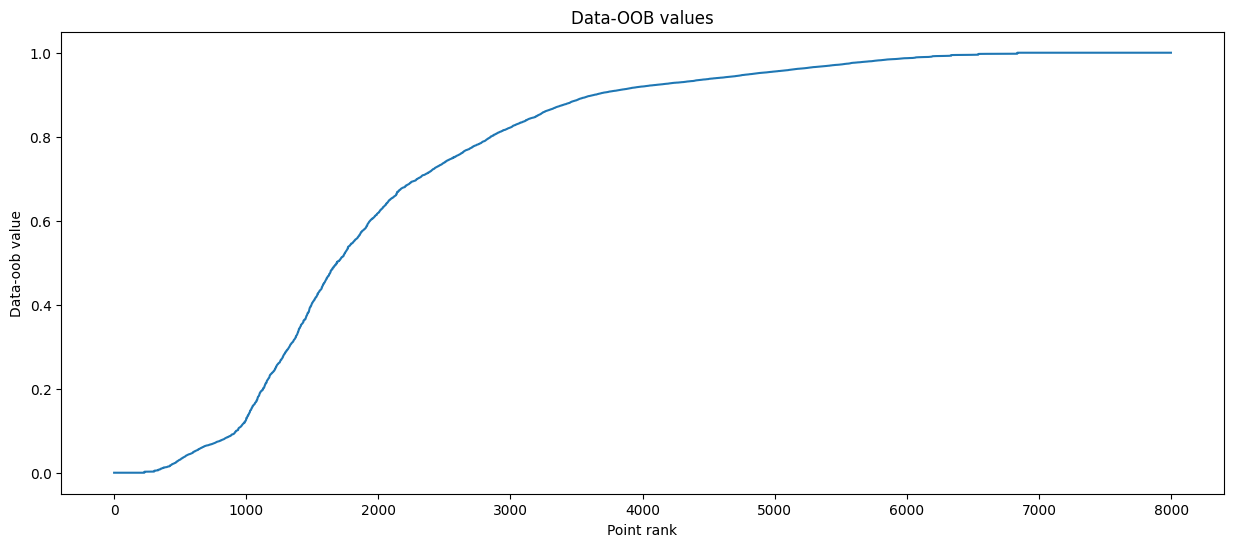

In [ ]:
oob_values.sort(key="value")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])

ax.plot(np.arange(len(oob_values.values)), oob_values.values)
ax.set_title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

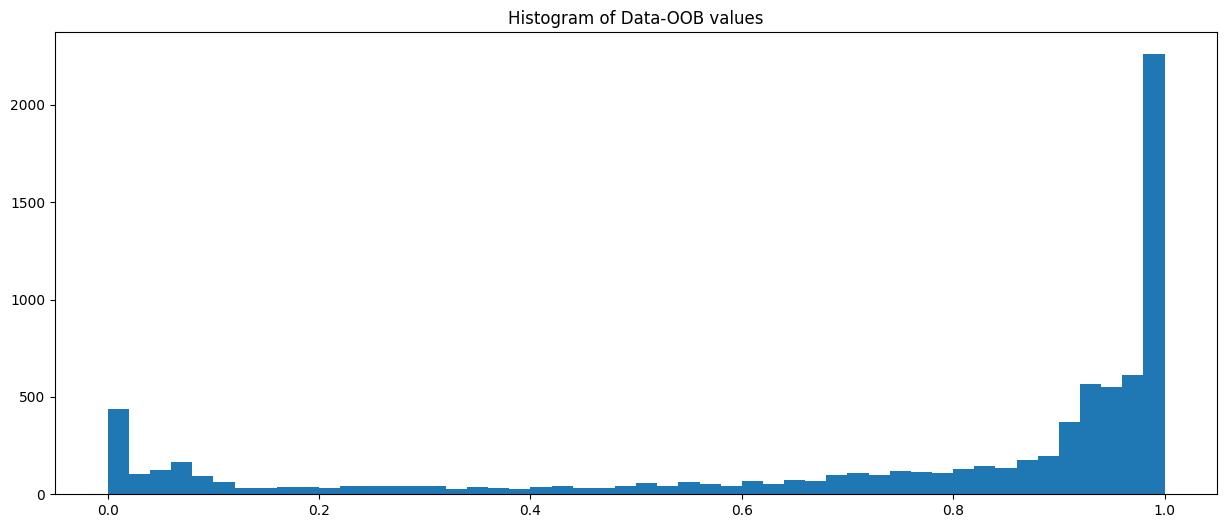

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])
ax.hist(oob_values.values, bins=50)
ax.set_title("Histogram of Data-OOB values");

## Variance

The variance it the weak learner variance. It is computed with Welford's online algorithm.

In [ ]:
plot_list = [(a, b) for a, b in zip(oob_values.values, oob_values.variances)]
plot_list = pd.DataFrame(plot_list).sample(100).sort_values(by=0).values
yerr = [x[1] ** 2 for x in plot_list]

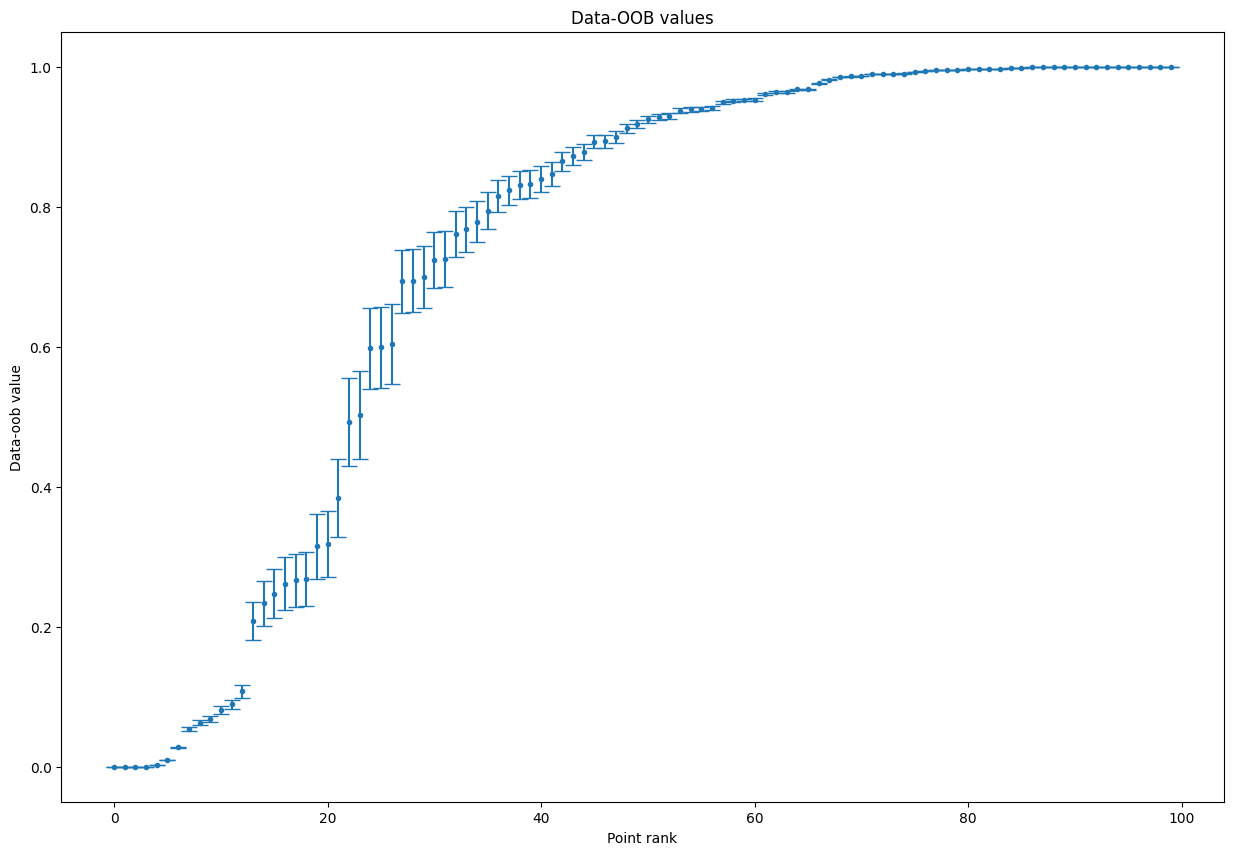

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 10])
ax.errorbar(
    x=np.arange(len(yerr)), y=[x[0] for x in plot_list], yerr=yerr, fmt=".", capsize=6
)
plt.title("Data-OOB values")
ax.set_ylabel("Data-oob value")
ax.set_xlabel("Point rank");

# Point removal experiments

The standard procedure for the evaluation of data valuation schemes is the point removal experiment. The objective is to measure the evolution of performance when the best/worst points are removed from the training set. 

In [ ]:
mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]

In [ ]:
all_best_scores = []
all_worst_scores = []

removal_percentages = np.arange(0, 0.99, 0.01)

for i in range(5):
    for method_name in ["Random", "oob"]:
        if method_name == "Random":
            values = ValuationResult.from_random(size=len(utility.data))
        else:
            values = compute_data_oob(utility, n_est=300, max_samples=0.95)

        best_scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
            remove_best=True,
        )
        best_scores["method_name"] = method_name
        all_best_scores.append(best_scores)

        worst_scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
            remove_best=False,
        )
        worst_scores["method_name"] = method_name
        all_worst_scores.append(worst_scores)

best_scores_df = pd.DataFrame(all_best_scores)
worst_scores_df = pd.DataFrame(all_worst_scores)

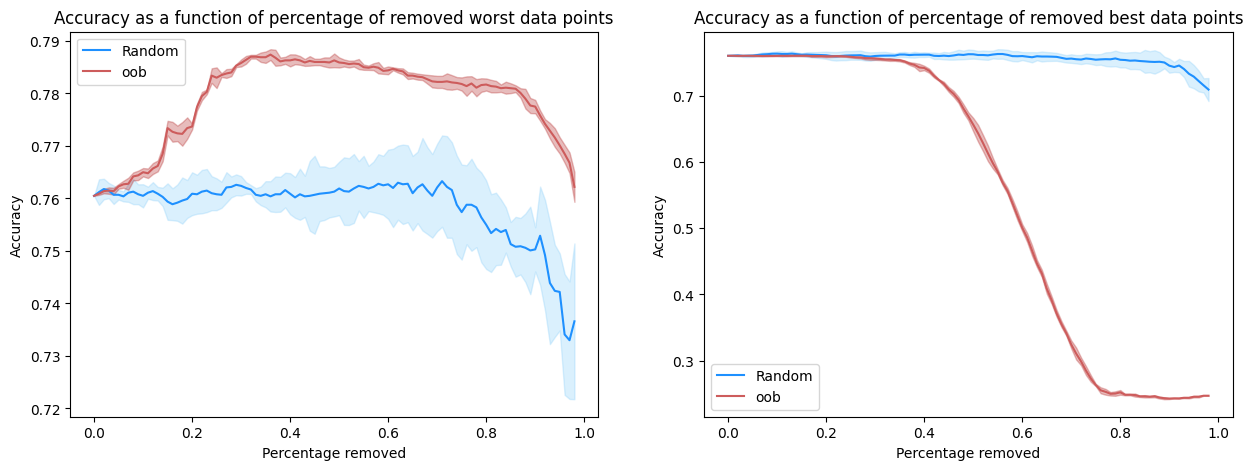

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for i, method_name in enumerate(["Random", "oob"]):
    shaded_mean_std(
        best_scores_df[best_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage removed",
        ylabel=utility.scorer._name.capitalize(),
        label=method_name,
        title="Accuracy as a function of percentage of removed best data points",
        ax=ax[1],
    )
    shaded_mean_std(
        worst_scores_df[worst_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage removed",
        ylabel=utility.scorer._name.capitalize(),
        label=method_name,
        title="Accuracy as a function of percentage of removed worst data points",
        ax=ax[0],
    )
ax[0].legend()
ax[1].legend()
plt.show();